# Dimensionality Reduction

Garbage in, garbage out—throughout this notebook, this pattern will be seen when applying machine learning methods to data. Looking back, it can be seen that the most interesting machine learning challenges always involved some sort of feature engineering, where the insight was tried to be used into the problem to carefully craft additional features that the model hopefully would pick up.

In this notebook, it will go in the opposite direction with dimensionality reduction, cutting away features that are irrelevant or redundant. If there are redundant features in the dataset, wouldn't the learning algorithm be able to quickly figure it out and set their weights to 0? There are, indeed, good reasons for trimming down the dimensions
as much as possible:
* Superfluous features can irritate or mislead the learner. most of the models feel safer with fewer dimensions.
* Another point against high-dimensional feature spaces is that more features mean more parameters to tune and a higher risk of overfitting.
* The retrieved data to solve the task might just have artificially high dimensionality, whereas the real dimension might be small.
* Fewer dimensions equals to faster training equals to more parameter variations to try out in the same time frame equals to better end result.
* Trimming down dimensions is better for visualization. If the data wants to be visualized, it will be restricted to two or three dimensions.

In this chapter, we will show you how to get rid of the garbage within our data while keeping the real valuable part of it.

## Sketching the roadmap

Dimensionality reduction can be roughly grouped into feature selection and feature projection methods. Some kind of feature selection have been already employed in almost every chapter so far when some features are invented, analyzed, and then probably dropped. Feature projection tries to transform the original feature space into a lower-dimensional feature space. This is especially useful when features cannot be removed of using selection methods, but there are still too many features for the learner. This will be demonstrated using principal component analysis (PCA), linear discriminant analysis (LDA), and multidimensional scaling (MDS).

## Selecting features

If the goal is to be nice to the machine learning algorithm, it is provided with features that are not dependent on each other, but which are highly dependent on the value that is to be predicted. This means that each feature adds salient information. Removing any of the features will lead to a drop in performance.

If there is only have a handful of features, a matrix of scatter plots could be drawn (one scatter plot for each feature pair combination). For every feature pair showing an obvious dependence, then think of whether one of them should be removed or better design a newer, cleaner feature out of both.

Most of the time, however, there are more than a handful of features to choose from. We will present two general ways to do so in the following subsections.

### Detecting redundant features using filters

Filters try to clean up the feature space independent of any later-used machine learning method. In general, a filter works as depicted in the following workflow:
# ![Filter workflow](./filter%20workflow.PNG)

First, features that are redundant are filter out using statistics that only take into account the training data. Then check whether the remaining features are useful in classifying the label.

#### Correlation

Using correlation, linear relationships between pairs of features can be easily seen. The correlation coefficient Cor(X1, X2) at the top of the individual graphs is calculated using the common Pearson correlation coefficient (pearson value) by means of the pearsonr() function of scipy.stat.

Given two equal-sized data series, it returns a tuple of the correlation coefficient value and the p-value. The p-value describes how likely it is that the data series has been generated by an uncorrelated system. In other words, the higher the p-value, the less we should trust the correlation coefficient:

In [1]:
from scipy.stats import pearsonr

print(pearsonr([1,2,3], [1,2,3.1]))
print(pearsonr([1,2,3], [1,20,6]))

(0.9996222851612185, 0.017498096813275913)
(0.25383654128340477, 0.836614936682275)


In the first case, there is a clear indication that both series are correlated. In the second case, there is still a clearly nonzero <i>r<i> value.

However, the p-value of 0.84 tells us that the correlation coefficient is not significant, and it should not be paid too much attention. In the first three cases that have high correlation coefficients in the following graph, either X1 or X2 would probably want to be thrown out because they seem to convey similar, if not the same, information:

<Figure size 432x288 with 0 Axes>

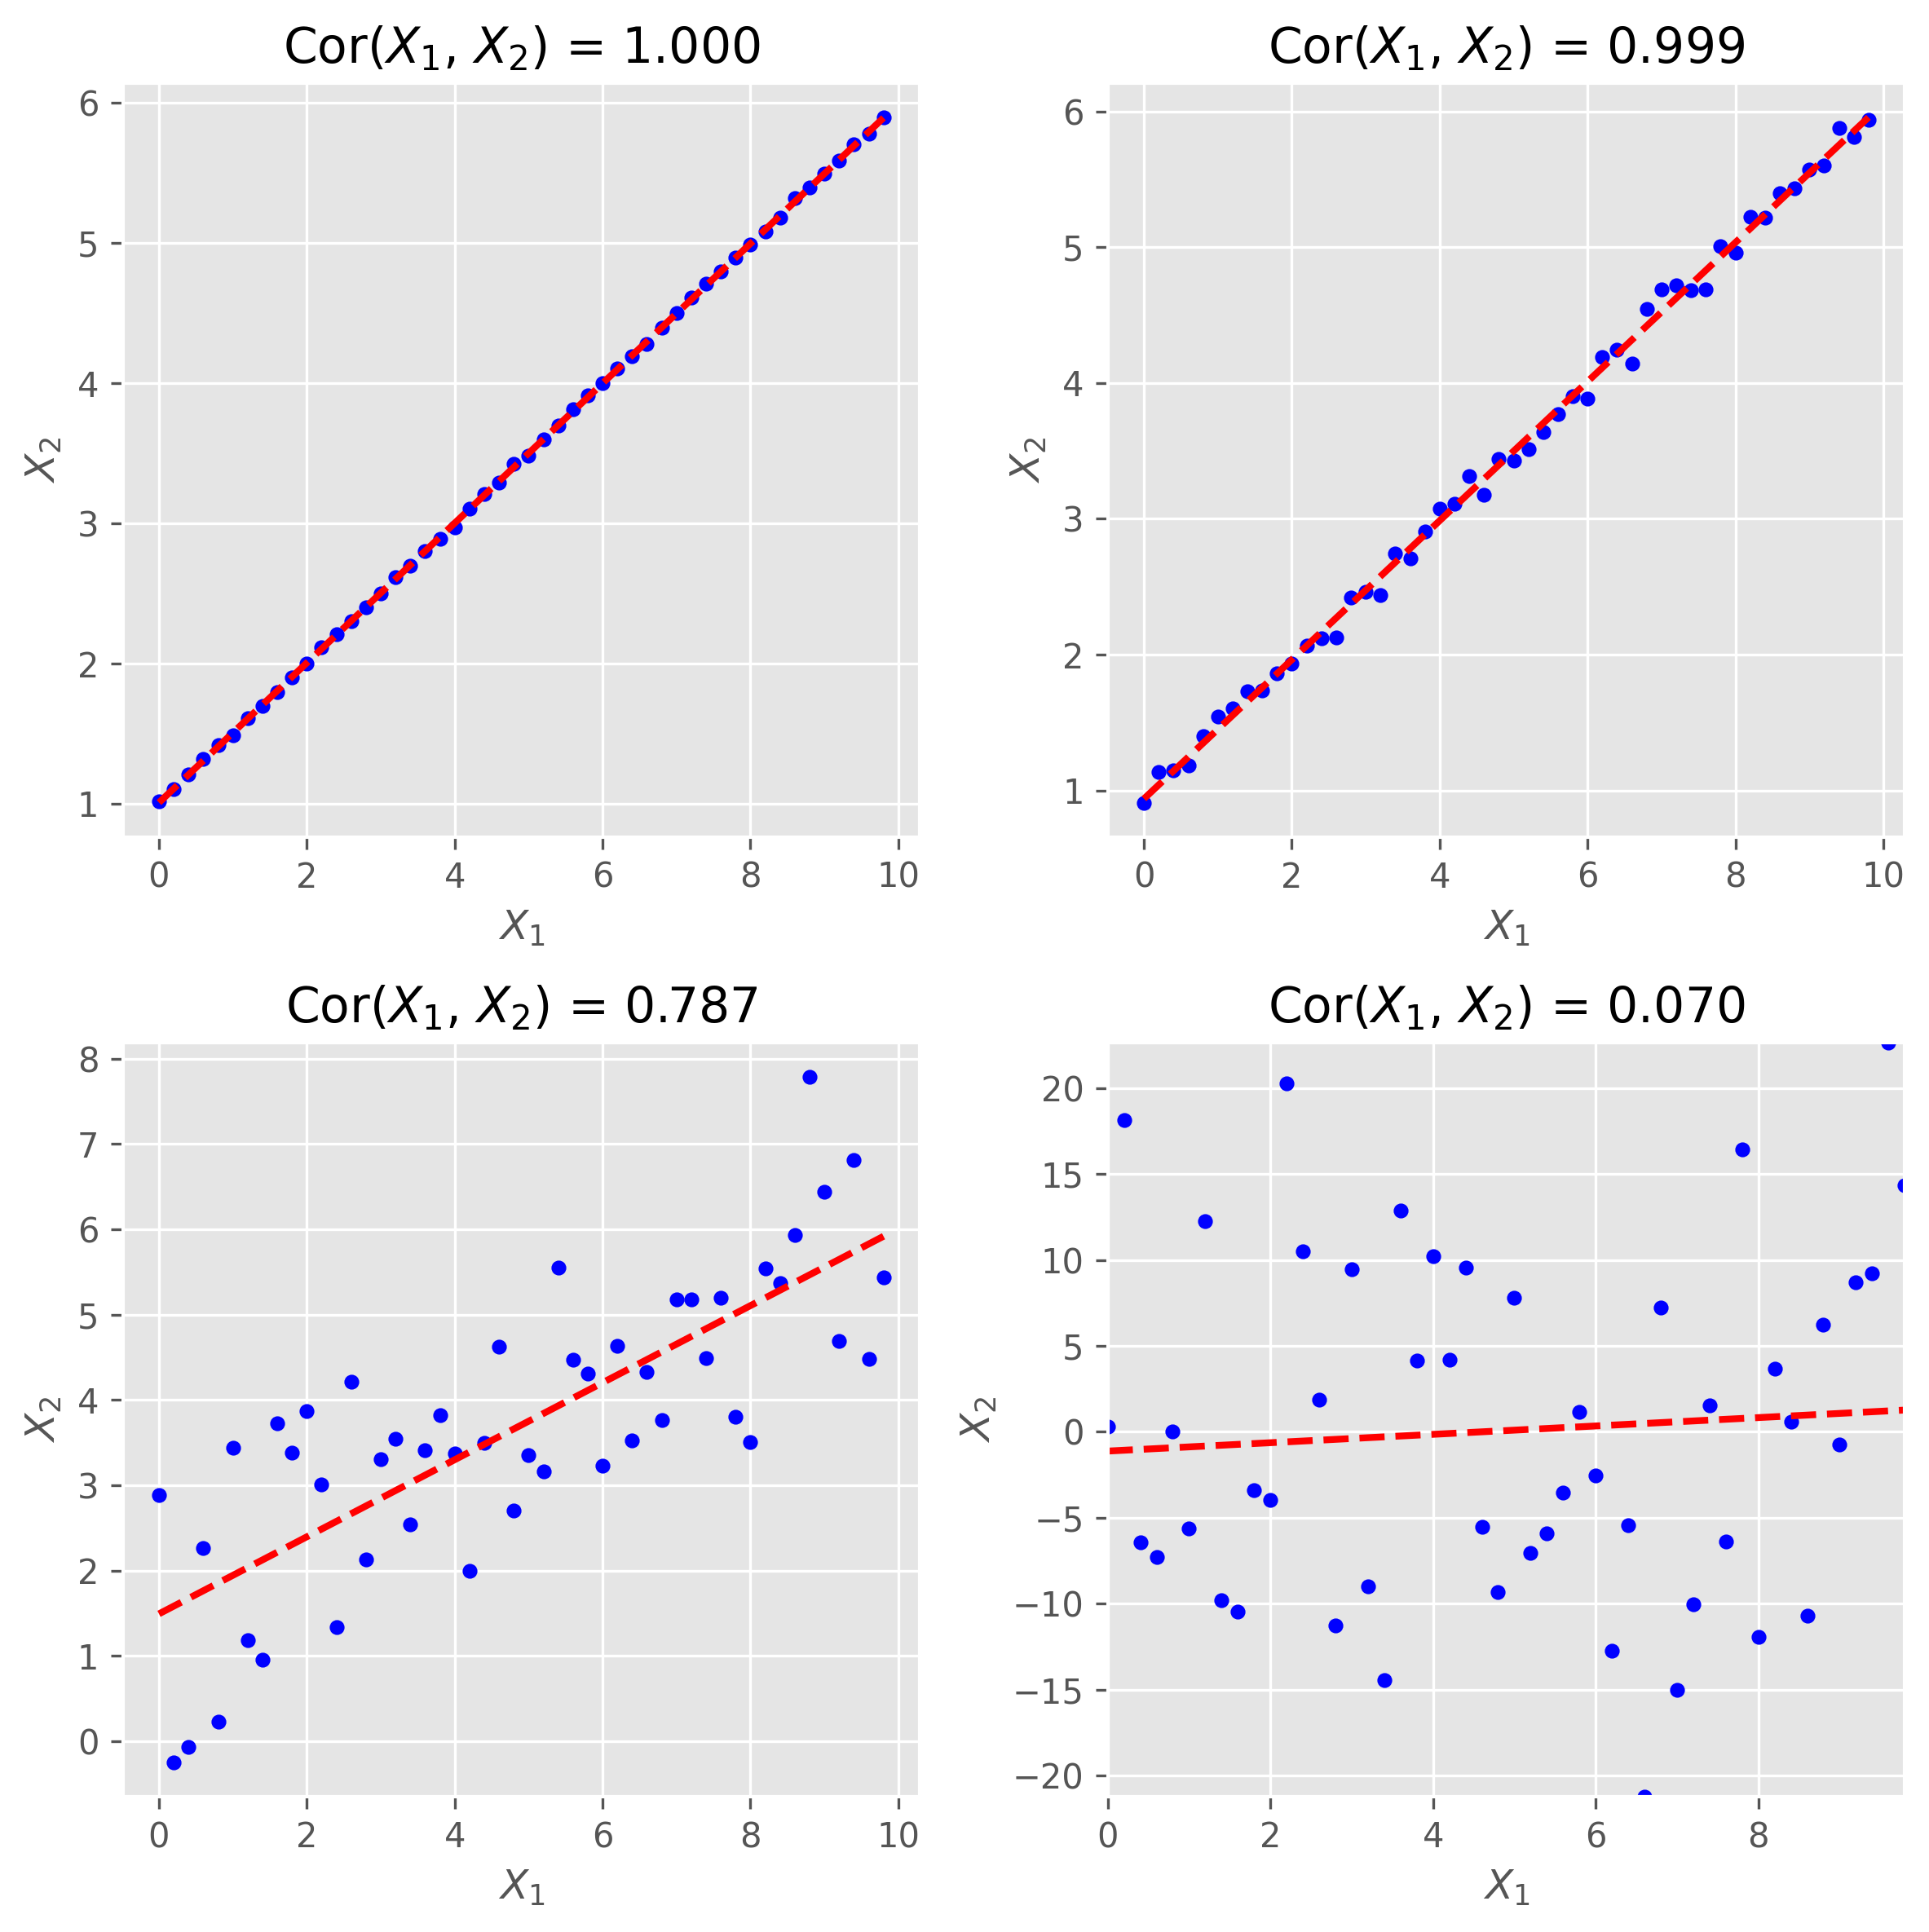

In [2]:

from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy
import numpy as np

def _plot_correlation_func(x, y):
    r, p = pearsonr(x, y)
    plt.scatter(x, y, c='b', s=15)
    plt.title("Cor($X_1$, $X_2$) = %.3f" % r)
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")

    f1 = scipy.poly1d(np.polyfit(x, y, 1))
    plt.plot(x, f1(x), "r--", linewidth=2)

DPI = 300

np.random.seed(0)  # to reproduce the data later on
plt.clf()
plt.figure(num=None, figsize=(8, 8), dpi=DPI)

x = np.arange(0, 10, 0.2)

plt.subplot(221)
y = 0.5 * x + norm.rvs(1, scale=.01, size=len(x))
_plot_correlation_func(x, y)

plt.subplot(222)
y = 0.5 * x + norm.rvs(1, scale=.1, size=len(x))
_plot_correlation_func(x, y)

plt.subplot(223)
y = 0.5 * x + norm.rvs(1, scale=1, size=len(x))
_plot_correlation_func(x, y)

plt.subplot(224)
y = norm.rvs(1, scale=10, size=len(x))
_plot_correlation_func(x, y)

plt.autoscale(tight=True)
plt.grid(True)
plt.tight_layout()
plt.show()

In the last case, however, both features should be kept. In the application, this decision would, of course, be driven by this p-value.

Although it worked nicely in the preceding example, reality is seldom nice. The problem can be seen if correlation is used on nonlinear data. In the following example, there is a quadratic relationship:

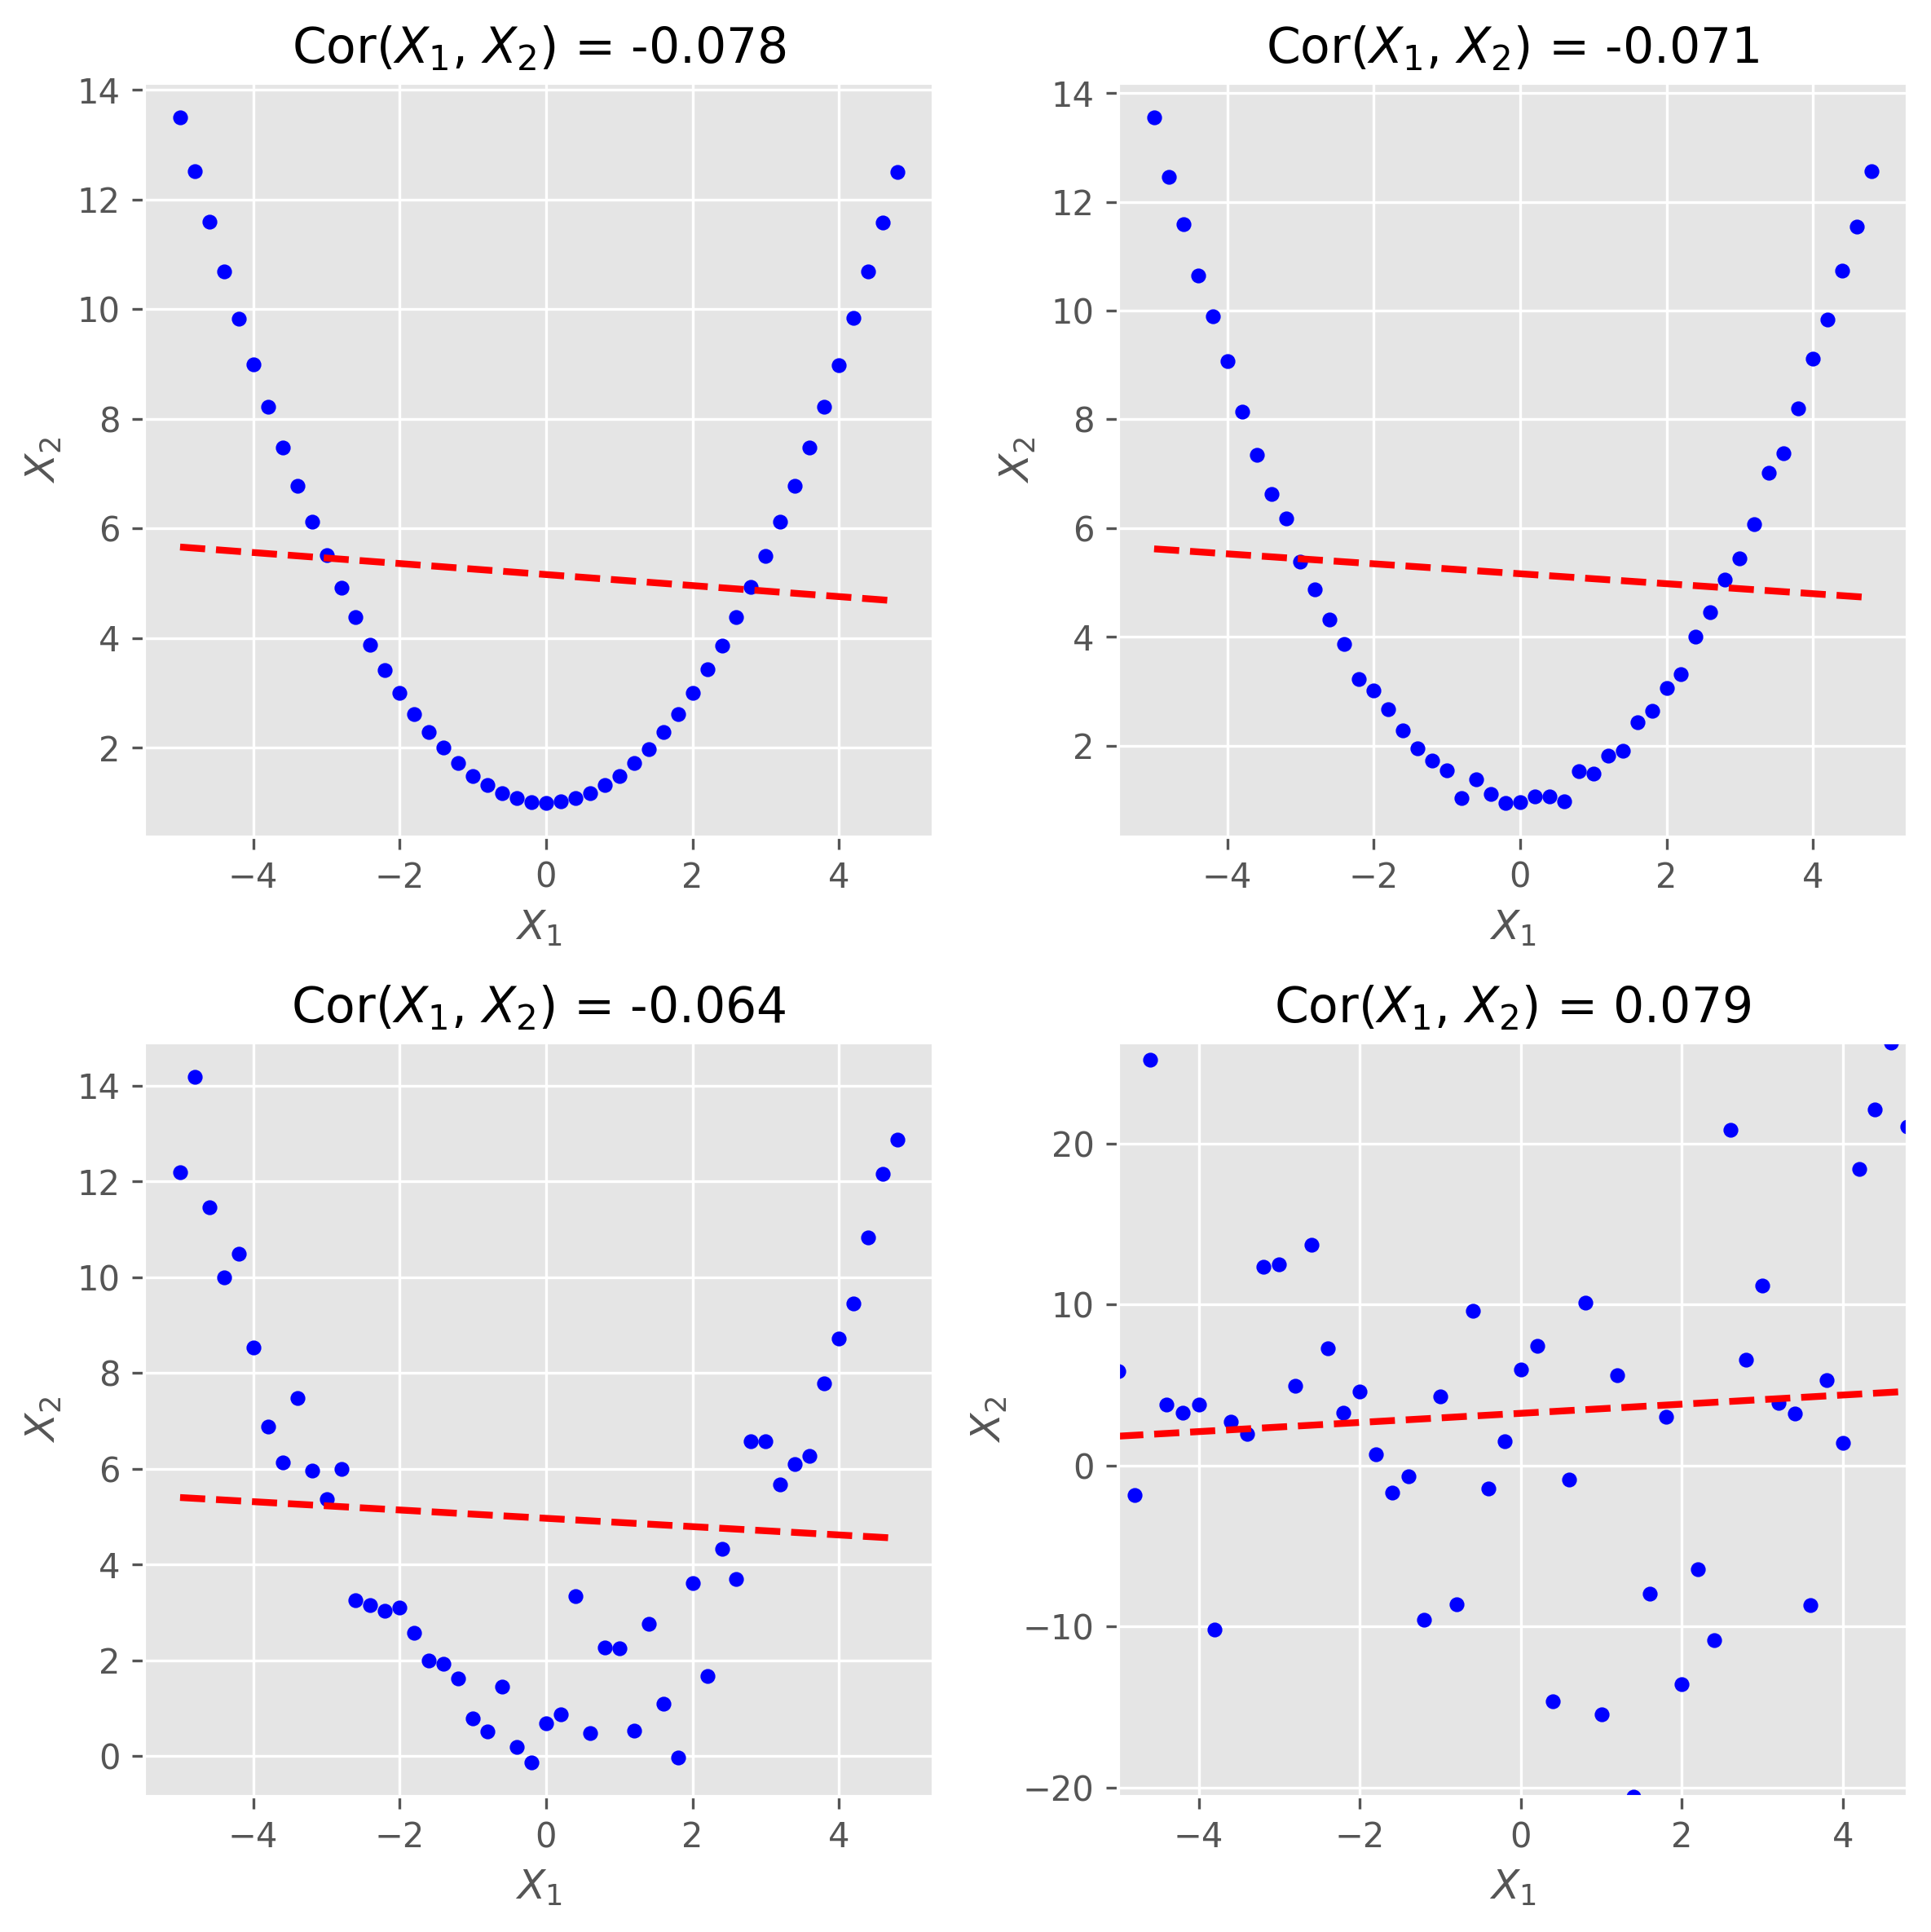

In [3]:
plt.figure(num=None, figsize=(8, 8), dpi=DPI)

x = np.arange(-5, 5, 0.2)

plt.subplot(221)
y = 0.5 * x ** 2 + norm.rvs(1, scale=.01, size=len(x))
_plot_correlation_func(x, y)

plt.subplot(222)
y = 0.5 * x ** 2 + norm.rvs(1, scale=.1, size=len(x))
_plot_correlation_func(x, y)

plt.subplot(223)
y = 0.5 * x ** 2 + norm.rvs(1, scale=1, size=len(x))
_plot_correlation_func(x, y)

plt.subplot(224)
y = 0.5 * x ** 2 + norm.rvs(1, scale=10, size=len(x))
_plot_correlation_func(x, y)

plt.autoscale(tight=True)
plt.grid(True)
plt.tight_layout()
plt.show()


Although the human eye immediately sees the relationship between X1 and X2 in all but the bottom-right graph, the correlation coefficient does not. Sometimes, it really helps to apply simple transformations to get a linear relationship. For instance, in the preceding plot, a high correlation coefficient would have been obtained if X2 over X1 squared had been drawn. Normal data, however, seldom offers this opportunity.

Luckily, for nonlinear relationships, mutual information comes to the rescue.

#### Mutual information

When looking at feature selection, do not focus on the type of relationship as it was done in the previous section (linear relationships). Instead, think in terms of how much information one feature provides, given that there is already another.

To understand this, pretend that features from the house_size, number_of_levels, and avg_rent_price feature sets will be used to train a classifier that outputs whether the house has an elevator or not. In this example, it can be intuitively seen that, knowing house_size, it doesn't need to know number_of_levels anymore, as it contains, somehow, redundant information. With avg_rent_price, it's different because it cannot infer the value of rental space simply from the size of the house or the number of levels it has. Hence, it would be wise to keep only one of them, in addition to the average price of rental space.

Mutual information formalizes the aforementioned reasoning by calculating how much information the two features have in common. However, unlike correlation, it does not rely on the sequence of data, but on the distribution. To understand how it works, it is necessery to dive into information entropy.

Assume there is a fair coin. Before it is flipped, maximum uncertainty will be obtained as to whether it will show heads or tails, as each outcome has an equal probability of 50 percent. This uncertainty can be measured by means of Claude Shannon's information entropy:

# ![Means of Claude Shannon's information entropy](./Means%20of%20Claude%20Shannon's%20information%20entropy.PNG)

In the fair coin case, there are two cases: let X0 be the case of heads and X1 the case of tails with
# ![Coin Probability](./Coin%20Probability.PNG)

Hence, it concludes in the following:|

# ![Means of Claude Shannon's information entropy for coin case](./Means%20of%20Claude%20Shannon's%20information%20entropy%20for%20coin%20case.PNG)

For convenience, scipy.stats.entropy([0.5, 0.5], base=2) can be also used. The base parameter is set to 2 to get the same result as earlier. Otherwise, the function will use the natural logarithm via np.log(). In general, the base does not matter (as long as it is used consistently).

Now, imagine that it was known upfront that the coin is actually not that fair, with heads having a 60 percent chance of showing up after flipping:

# ![Means of Claude Shannon's information entropy for coin case result](./Means%20of%20Claude%20Shannon's%20information%20entropy%20for%20coin%20case%20result.PNG)

It can be seen that this situation is less uncertain. The uncertainty will decrease the further away it get from 0.5, reaching the extreme value of 0 for either 0 percent or 100 percent probability of heads showing up, as it can be seen in the following graph:

<Figure size 432x288 with 0 Axes>

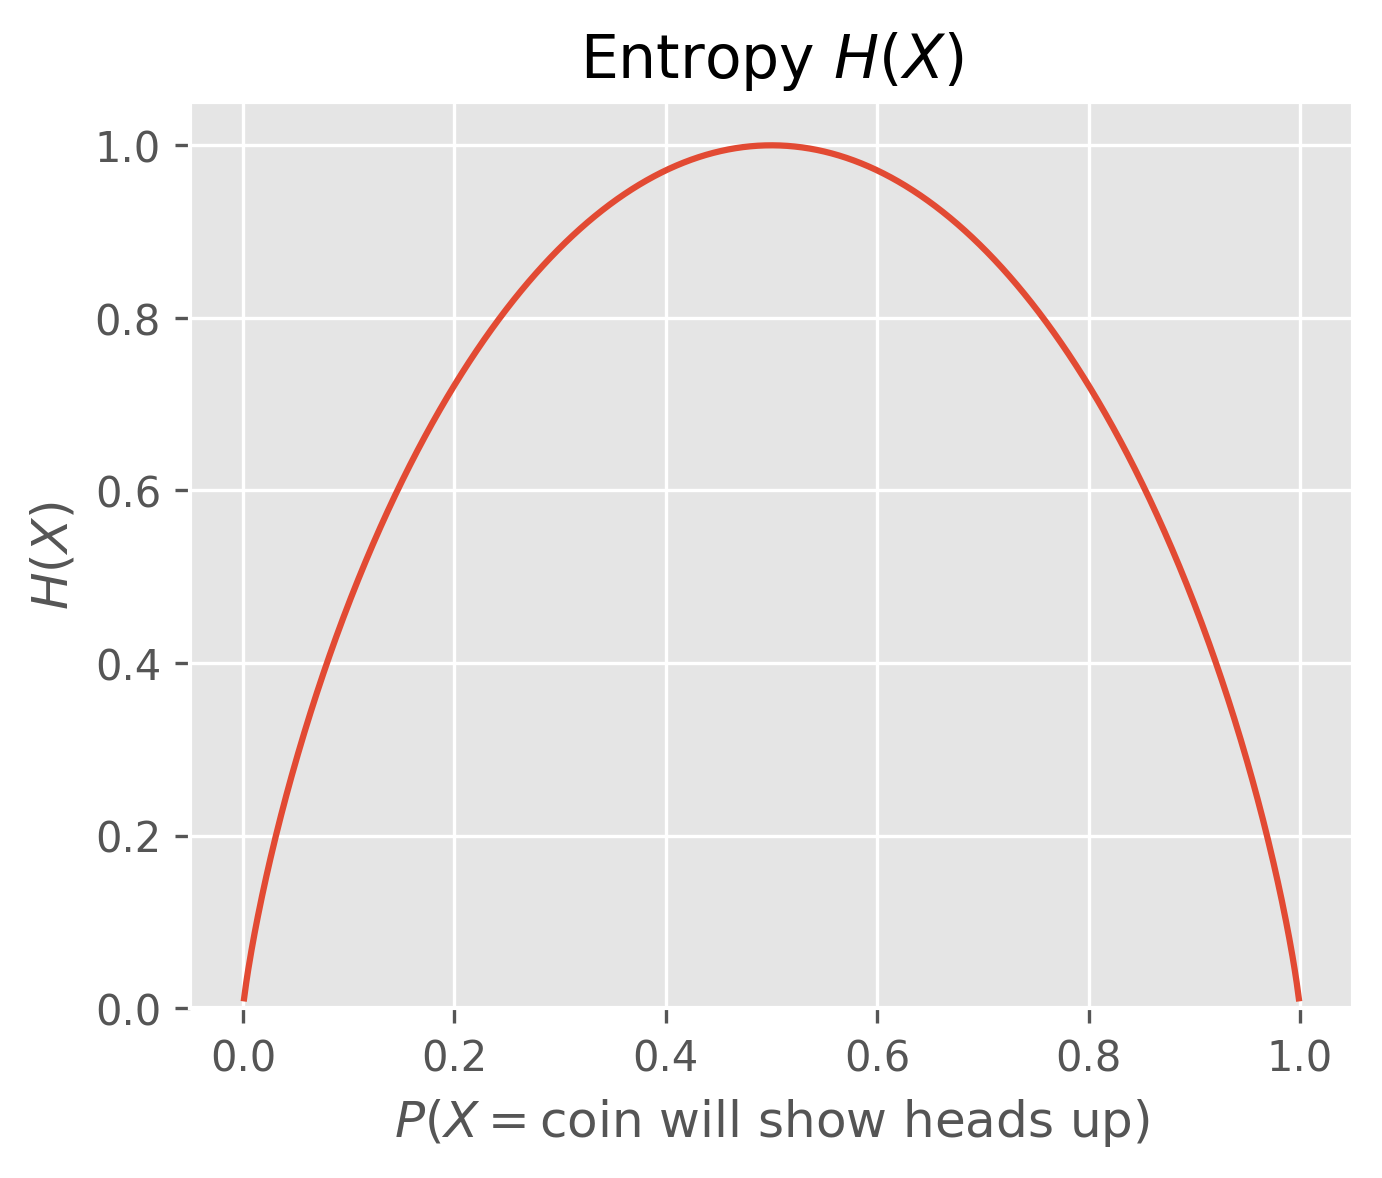

In [4]:
from scipy.stats import entropy

plt.clf()
plt.figure(num=None, figsize=(5, 4), dpi=DPI)

plt.title("Entropy $H(X)$")
plt.xlabel("$P(X=$coin will show heads up$)$")
plt.ylabel("$H(X)$")

plt.xlim(xmin=0, xmax=1.1)
x = np.arange(0.001, 1, 0.001)
y = -x * np.log2(x) - (1 - x) * np.log2(1 - x)
plt.plot(x, y)

plt.autoscale(tight=True)
plt.grid(True)
plt.ylim((0,1.05))
plt.xlim((-.05,1.05))
plt.show()

The entropy will be now modified, H(X), by applying it to two features instead of one in such a way that it measures how much uncertainty is removed from X when Y is learnt. Then, how one feature reduces the uncertainty of another can be caught.

For example, without having any further information about the weather, it is totally uncertain whether or not it's raining outside. If it is now learnt that the grass outside is wet, the uncertainty has been reduced (it will still have to check whether the sprinkler had been turned on).

More formally, mutual information is defined as the following:
# ![Mutual information](./Mutual%20information.PNG)


This looks a bit intimidating but is really nothing more than sums and products. For instance, the calculation of p() can be done by binning the feature values and then calculating the fraction of values in each bin. In the following plots, the number of bins have been set to ten.

In order to restrict mutual information to the interval of [0,1], it have to be divided by their added individual entropy, which gives the following normalized mutual information:
# ![Normalized mutual information](./Normalized%20mutual%20information.PNG)

The code is as follows:

<Figure size 432x288 with 0 Axes>

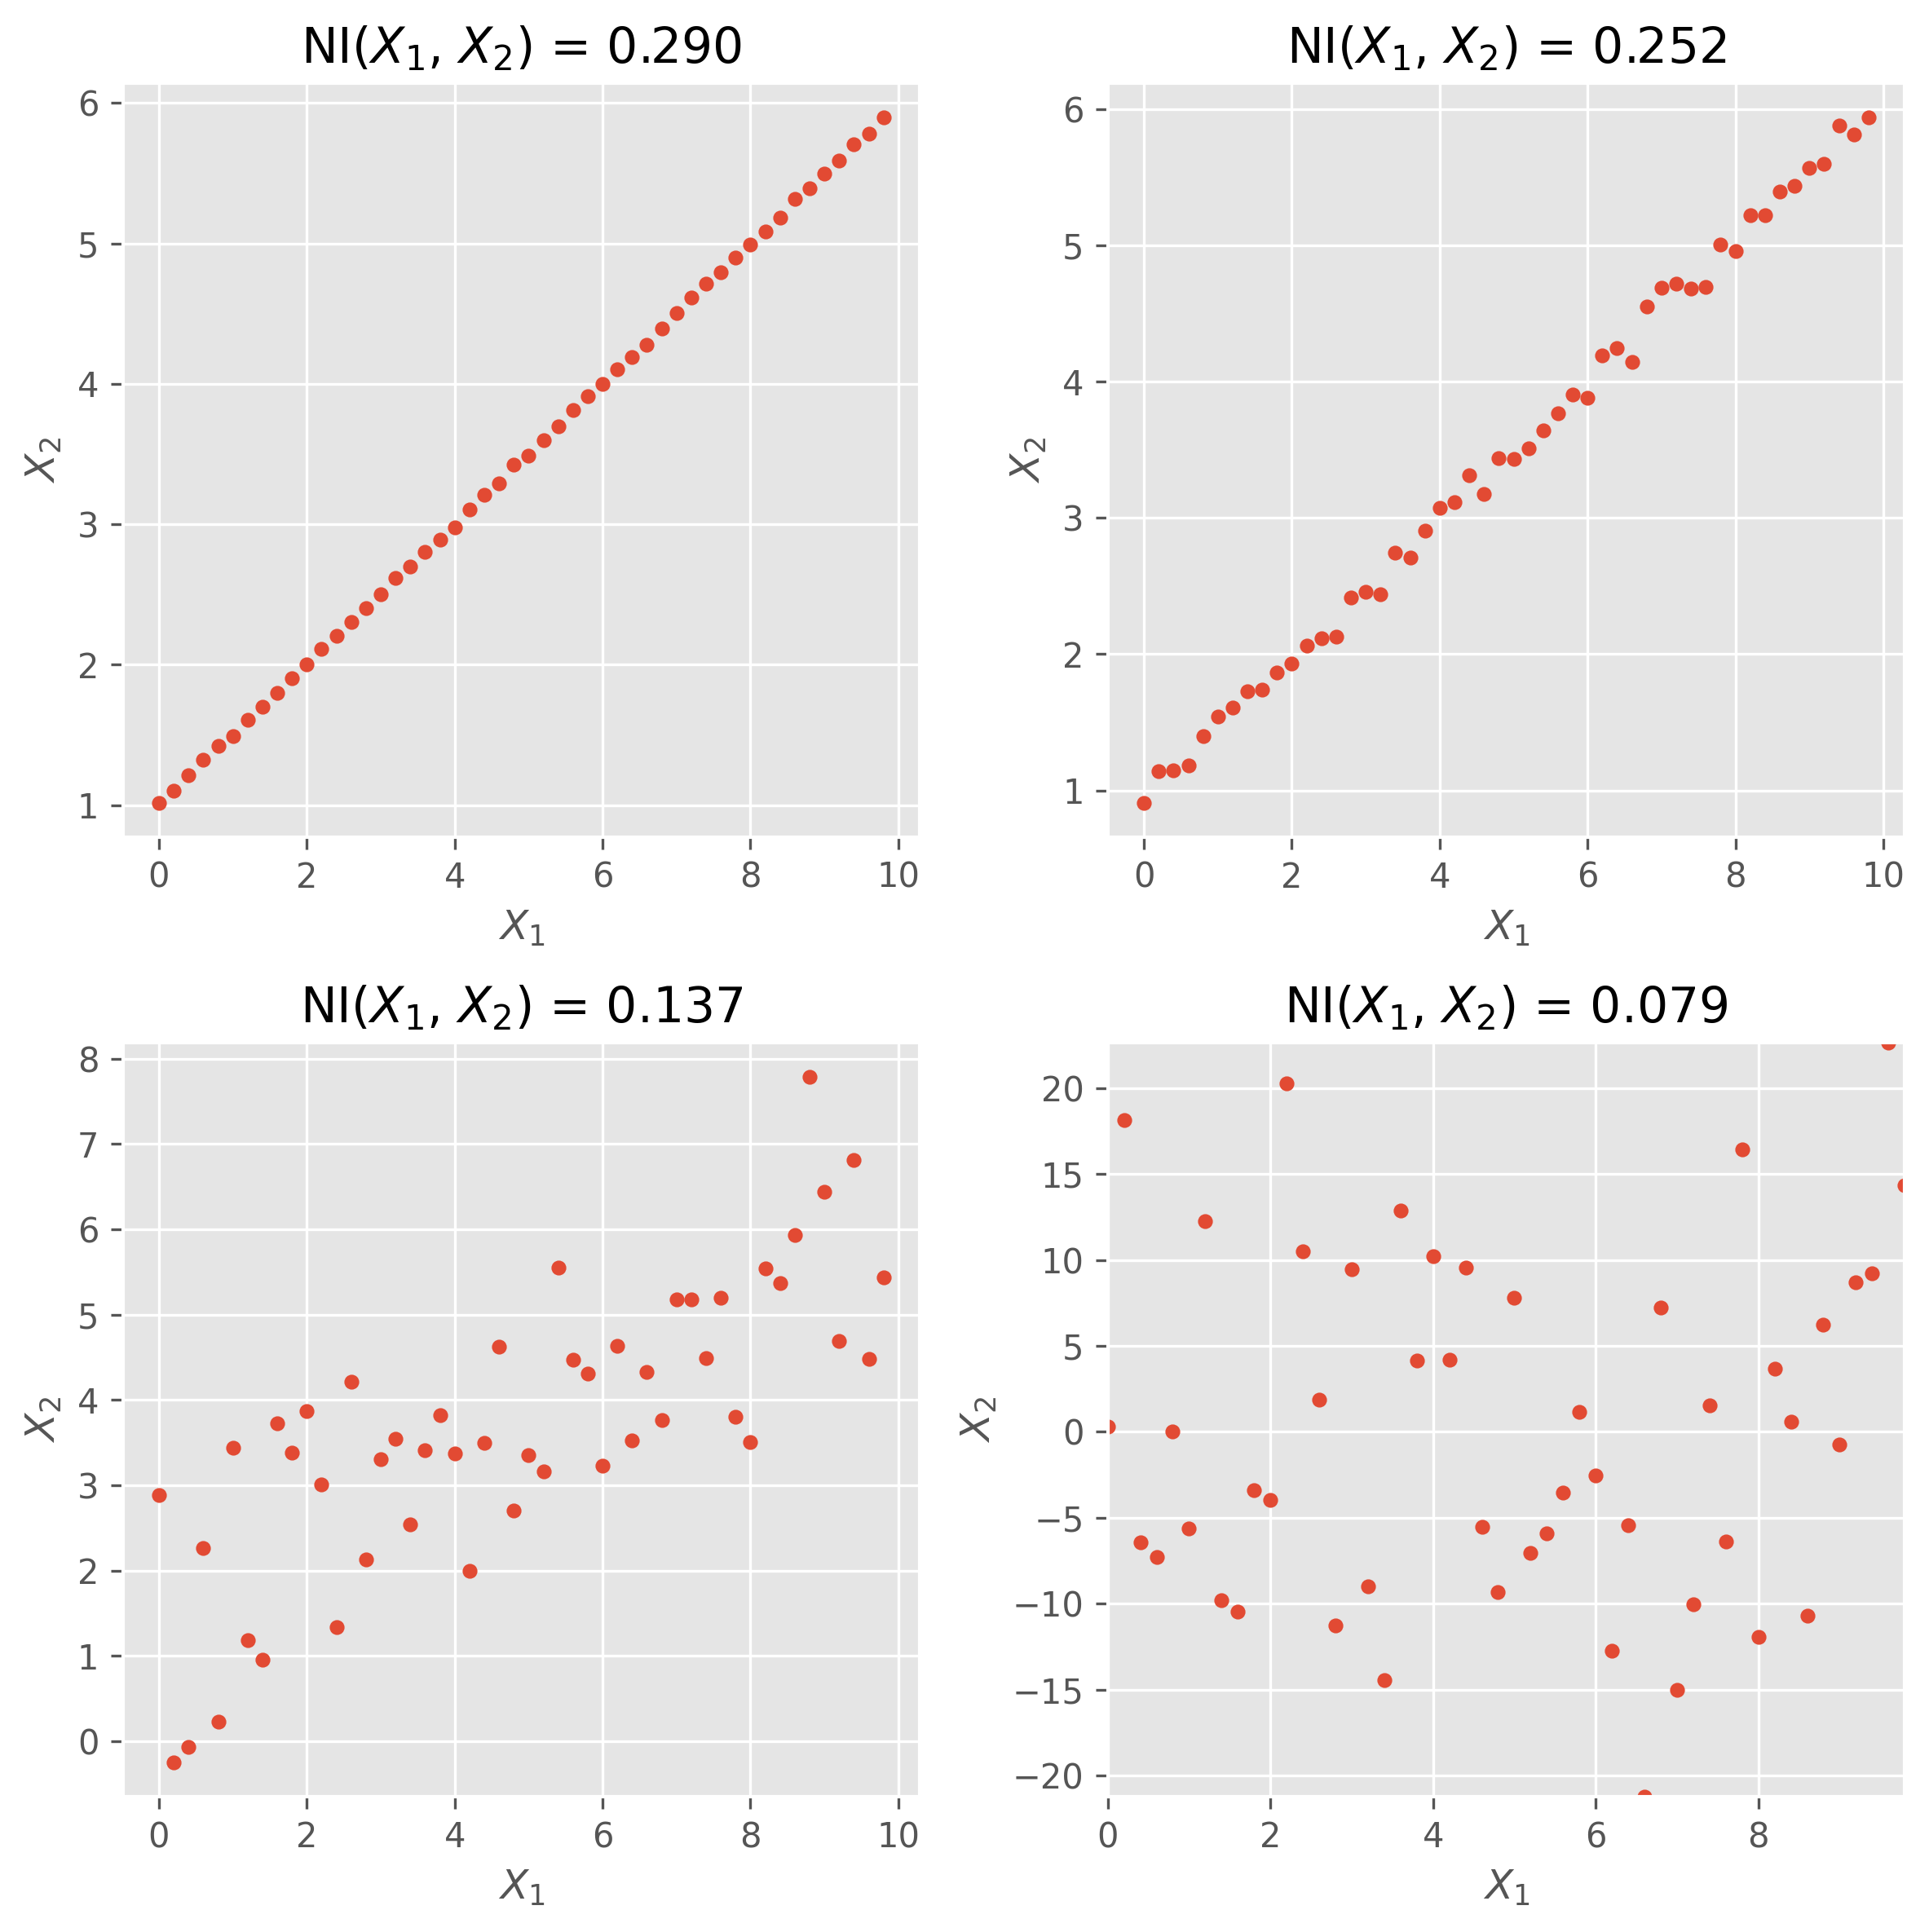

In [5]:
def normalized_mutual_info(x, y, bins=10):
    counts_xy, bins_x, bins_y = np.histogram2d(x, y, bins=(bins, bins))
    counts_x, bins = np.histogram(x, bins=bins)
    counts_y, bins = np.histogram(y, bins=bins)

    counts_xy += 1
    counts_x += 1
    counts_y += 1
    P_xy = counts_xy / np.sum(counts_xy)
    P_x = counts_x / np.sum(counts_x)
    P_y = counts_y / np.sum(counts_y)

    I_xy = np.sum(P_xy * np.log2(P_xy / (P_x.reshape(-1, 1) * P_y)))

    return I_xy / (entropy(counts_x) + entropy(counts_y))

def _plot_mi_func(x, y):
    mi = normalized_mutual_info(x, y)
    plt.scatter(x, y, s=15)
    plt.title("NI($X_1$, $X_2$) = %.3f" % mi)
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    

np.random.seed(0)  # to reproduce the data later on
plt.clf()
plt.figure(num=None, figsize=(8, 8), dpi=DPI)

x = np.arange(0, 10, 0.2)

plt.subplot(221)
y = 0.5 * x + norm.rvs(1, scale=.01, size=len(x))
_plot_mi_func(x, y)

plt.subplot(222)
y = 0.5 * x + norm.rvs(1, scale=.1, size=len(x))
_plot_mi_func(x, y)

plt.subplot(223)
y = 0.5 * x + norm.rvs(1, scale=1, size=len(x))
_plot_mi_func(x, y)

plt.subplot(224)
y = norm.rvs(1, scale=10, size=len(x))
_plot_mi_func(x, y)

plt.autoscale(tight=True)
plt.grid(True)
plt.tight_layout()
plt.show()

The nice thing about mutual information is that, unlike correlation, it does not only look at linear relationships, as it can be seen in the previous graphs.

As it can be seen, mutual information is able to indicate the strength of a linear relationship. The following diagram shows that it also works for squared relationships:

<Figure size 432x288 with 0 Axes>

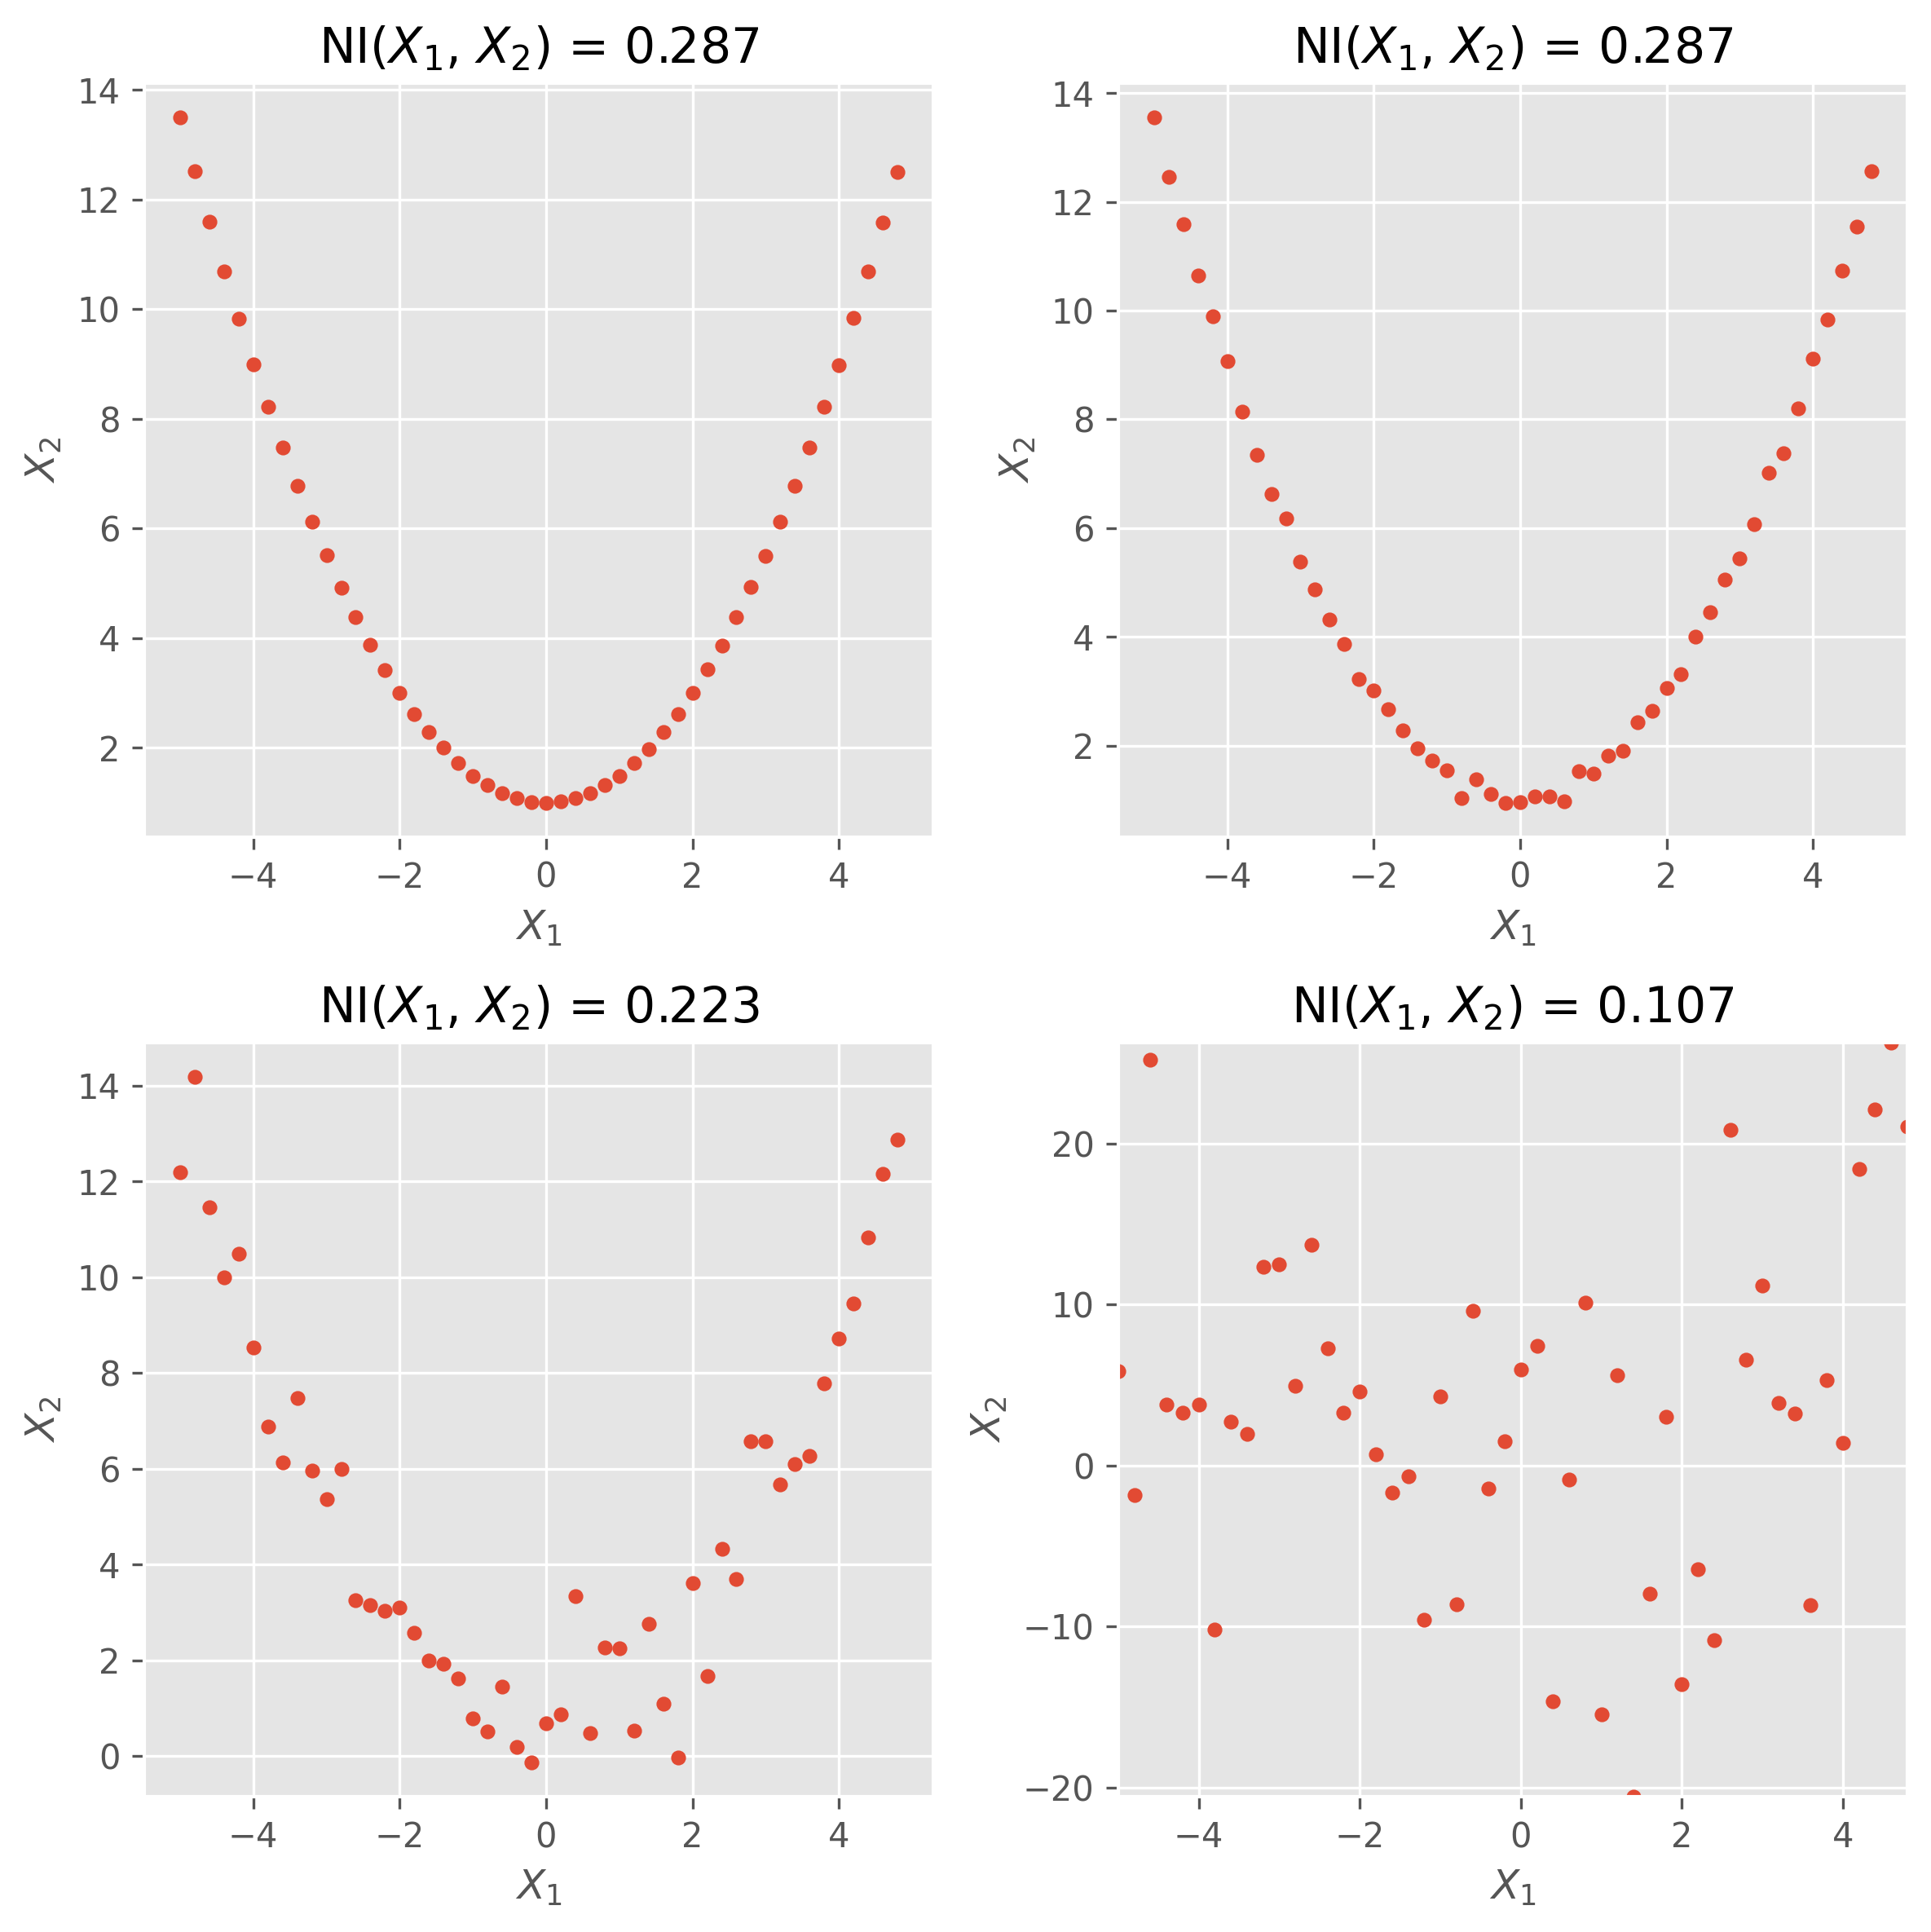

In [6]:
plt.clf()
plt.figure(num=None, figsize=(8, 8), dpi=DPI)

x = np.arange(-5, 5, 0.2)

plt.subplot(221)
y = 0.5 * x ** 2 + norm.rvs(1, scale=.01, size=len(x))
_plot_mi_func(x, y)

plt.subplot(222)
y = 0.5 * x ** 2 + norm.rvs(1, scale=.1, size=len(x))
_plot_mi_func(x, y)

plt.subplot(223)
y = 0.5 * x ** 2 + norm.rvs(1, scale=1, size=len(x))
_plot_mi_func(x, y)

plt.subplot(224)
y = 0.5 * x ** 2 + norm.rvs(1, scale=10, size=len(x))
_plot_mi_func(x, y)

plt.autoscale(tight=True)
plt.grid(True)
plt.tight_layout()
plt.show()

So, what would have to be done is calculate the normalized mutual information for all feature pairs. For every pair with too high a value (it would have to be determined what this means), it would be then dropped one of them. In the case of regression, the feature that has too little mutual information could be dropped with the desired result value.

This might work for a smallish set of features. At some point, however, this procedure can be really expensive, because the amount of calculation grows quadratically with the number of features.

Another huge disadvantage of filters is that they drop features that don't seem to be useful in isolation. More often than not, there are a handful of features that seem to be totally independent of the target variable, yet when combined, they rock. To keep these, wrappers are needed.

### Asking the model about the features using wrappers

While filters can help tremendously in getting rid of useless features, they can only go so far. After all the filtering, there might still be some features that are independent among themselves and that show some degree of dependence with the result variable, but that are totally useless from the model's point of view. Just think of the following data that describes the XOR function. Individually, neither A nor B would show any signs of dependence on Y, whereas together they clearly do:
# ![XOR data](./XOR%20data.PNG)

So, why not ask the model itself to give its vote on the individual features? This is what scikit wrappers do, as it can be seen in the following process chart:
# ![Wrappers chart](./Wrappers%20chart.PNG)

Here, the calculation of feature importance was pushed to the model training process. Unfortunately (but understandably), feature importance is not determined as a binary, but as a ranking value, so it still has to be specified where to make the cut, what part of the features that are willing to be taken, and what part it want to be dropped.

Coming back to scikit-learn, various excellent wrapper classes are found in the sklearn.feature_selection package. A real workhorse in this field is RFE, which stands for recursive feature elimination. The RFE instance itself pretends to be an estimator, thereby, indeed, wrapping the provided estimator.

In the following example, an artificial classification problem of 100 samples will be created using the dataset's convenient make_classification() function. It will specify the creation of 10 features, out of which only three are really valuable, to solve the classification problem:

In [7]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=10, n_informative=3, random_state=0)
clf = LogisticRegression()
selector = RFE(clf, n_features_to_select=3)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

[False False  True False False False  True  True False False]
[5 4 1 2 6 7 1 1 8 3]


The problem in real-world scenarios is, of course, how to know the right value for n_features_to_select? However, most of the time, a sample of the data can be used and play with it using different settings to quickly get a feeling for the right ballpark.

The good thing is that it doesn't have to be that exact using wrappers. Try different values for n_features_to_select to see how support_ and ranking_ change:

In [8]:
for i in range(1, 11):
    selector = RFE(clf, n_features_to_select=i)
    selector = selector.fit(X, y)
    print("{} \t {} \t {}".format(i, selector.support_, selector.ranking_))

1 	 [False False False False False False False  True False False] 	 [ 7  6  3  4  8  9  2  1 10  5]
2 	 [False False False False False False  True  True False False] 	 [6 5 2 3 7 8 1 1 9 4]
3 	 [False False  True False False False  True  True False False] 	 [5 4 1 2 6 7 1 1 8 3]
4 	 [False False  True  True False False  True  True False False] 	 [4 3 1 1 5 6 1 1 7 2]
5 	 [False False  True  True False False  True  True False  True] 	 [3 2 1 1 4 5 1 1 6 1]
6 	 [False  True  True  True False False  True  True False  True] 	 [2 1 1 1 3 4 1 1 5 1]
7 	 [ True  True  True  True False False  True  True False  True] 	 [1 1 1 1 2 3 1 1 4 1]
8 	 [ True  True  True  True  True False  True  True False  True] 	 [1 1 1 1 1 2 1 1 3 1]
9 	 [ True  True  True  True  True  True  True  True False  True] 	 [1 1 1 1 1 1 1 1 2 1]
10 	 [ True  True  True  True  True  True  True  True  True  True] 	 [1 1 1 1 1 1 1 1 1 1]


It can be seen that the result is very stable. Lastly, the train/test set splitting is done to warn when it goes the wrong way.

### Other feature selection methods

There are several other feature-selection methods that will be discovered while reading through machine learning literature. Some don't even look like they are feature selection methods because they are embedded in the learning process (not to be confused with the aforementioned wrappers). Decision trees, for instance, have a feature selection mechanism implanted deep in their core. Other learning methods employ some kind of regularization that punishes model complexity, hence driving the learning process toward good performing models that are still simple. They do this by decreasing the less impactful features' importance to zero and then dropping them (L1 regularization).

Often, the power of machine learning methods has to be attributed to their implanted feature selection methods to a great degree.

## Feature projection

At some point, after redundant features have been removed and irrelevant ones have been dropped, it will often still find that there are too many features. Another situation where the feature dimension needs to be reduced, and where feature selection does not help much, is when data wants to be visualized. Then, it needs to have, at most, three
dimensions at the end to provide any meaningful graphs.

Enter feature projection methods. They restructure the feature space to make it more accessible to the model, or simply cut down the dimensions to two or three so that dependencies can be shown visually.

Again, feature projection methods can be distinguished as being linear or nonlinear. Also, as seen before in the Selecting features section, one method will be presented for each type (principal component analysis as a linear and nonlinear version of multidimensional scaling). Although they are widely known and used, they are only a selection of the more interesting and powerful feature projection methods available.

### Principal component analysis

Principal component analysis (PCA) is often the first thing to try out if the goal is to cut down the number of features and do not know which feature projection method to use. Add to this the strong mathematical properties it offers, the speed at which it finds the transformed feature space, and the speed at which it is later able to transform between original and transformed features, and it can be almost guaranteed that it will also become one of
the frequently used machine learning tools.

To summarize, given the original feature space, PCA finds a linear projection of itself in a lower dimensional space that has the following properties:
* The conserved variance is maximized
* The final reconstruction error (when trying to go back from transformed features to the original ones) is minimized

As PCA simply transforms the input data, it can be applied to both classification and regression problems. In this section, a classification task will be used to discuss the method.

#### Sketching PCA

PCA involves a lot of linear algebra. Nevertheless, the basic algorithm's process can be easily described as follows:
1. Center the data by subtracting the mean from it
2. Calculate the covariance matrix
3. Calculate the eigenvectors of the covariance matrix

If it is started with N features, then the algorithm will return a transformed feature space with N dimensions (nothing has been gained so far). The nice thing about this algorithm, however, is that the eigenvalues indicate how much of the variance is described by the corresponding eigenvector.

Let's assume that it is started with N = 1000 features and that it is known that the model does not work well with more than 20 features. Then, the 20 eigenvectors with the highest eigenvalues are simply picked.

#### Applying PCA

Consider the following artificial dataset, which is visualized in the following plot diagram:

<Figure size 432x288 with 0 Axes>

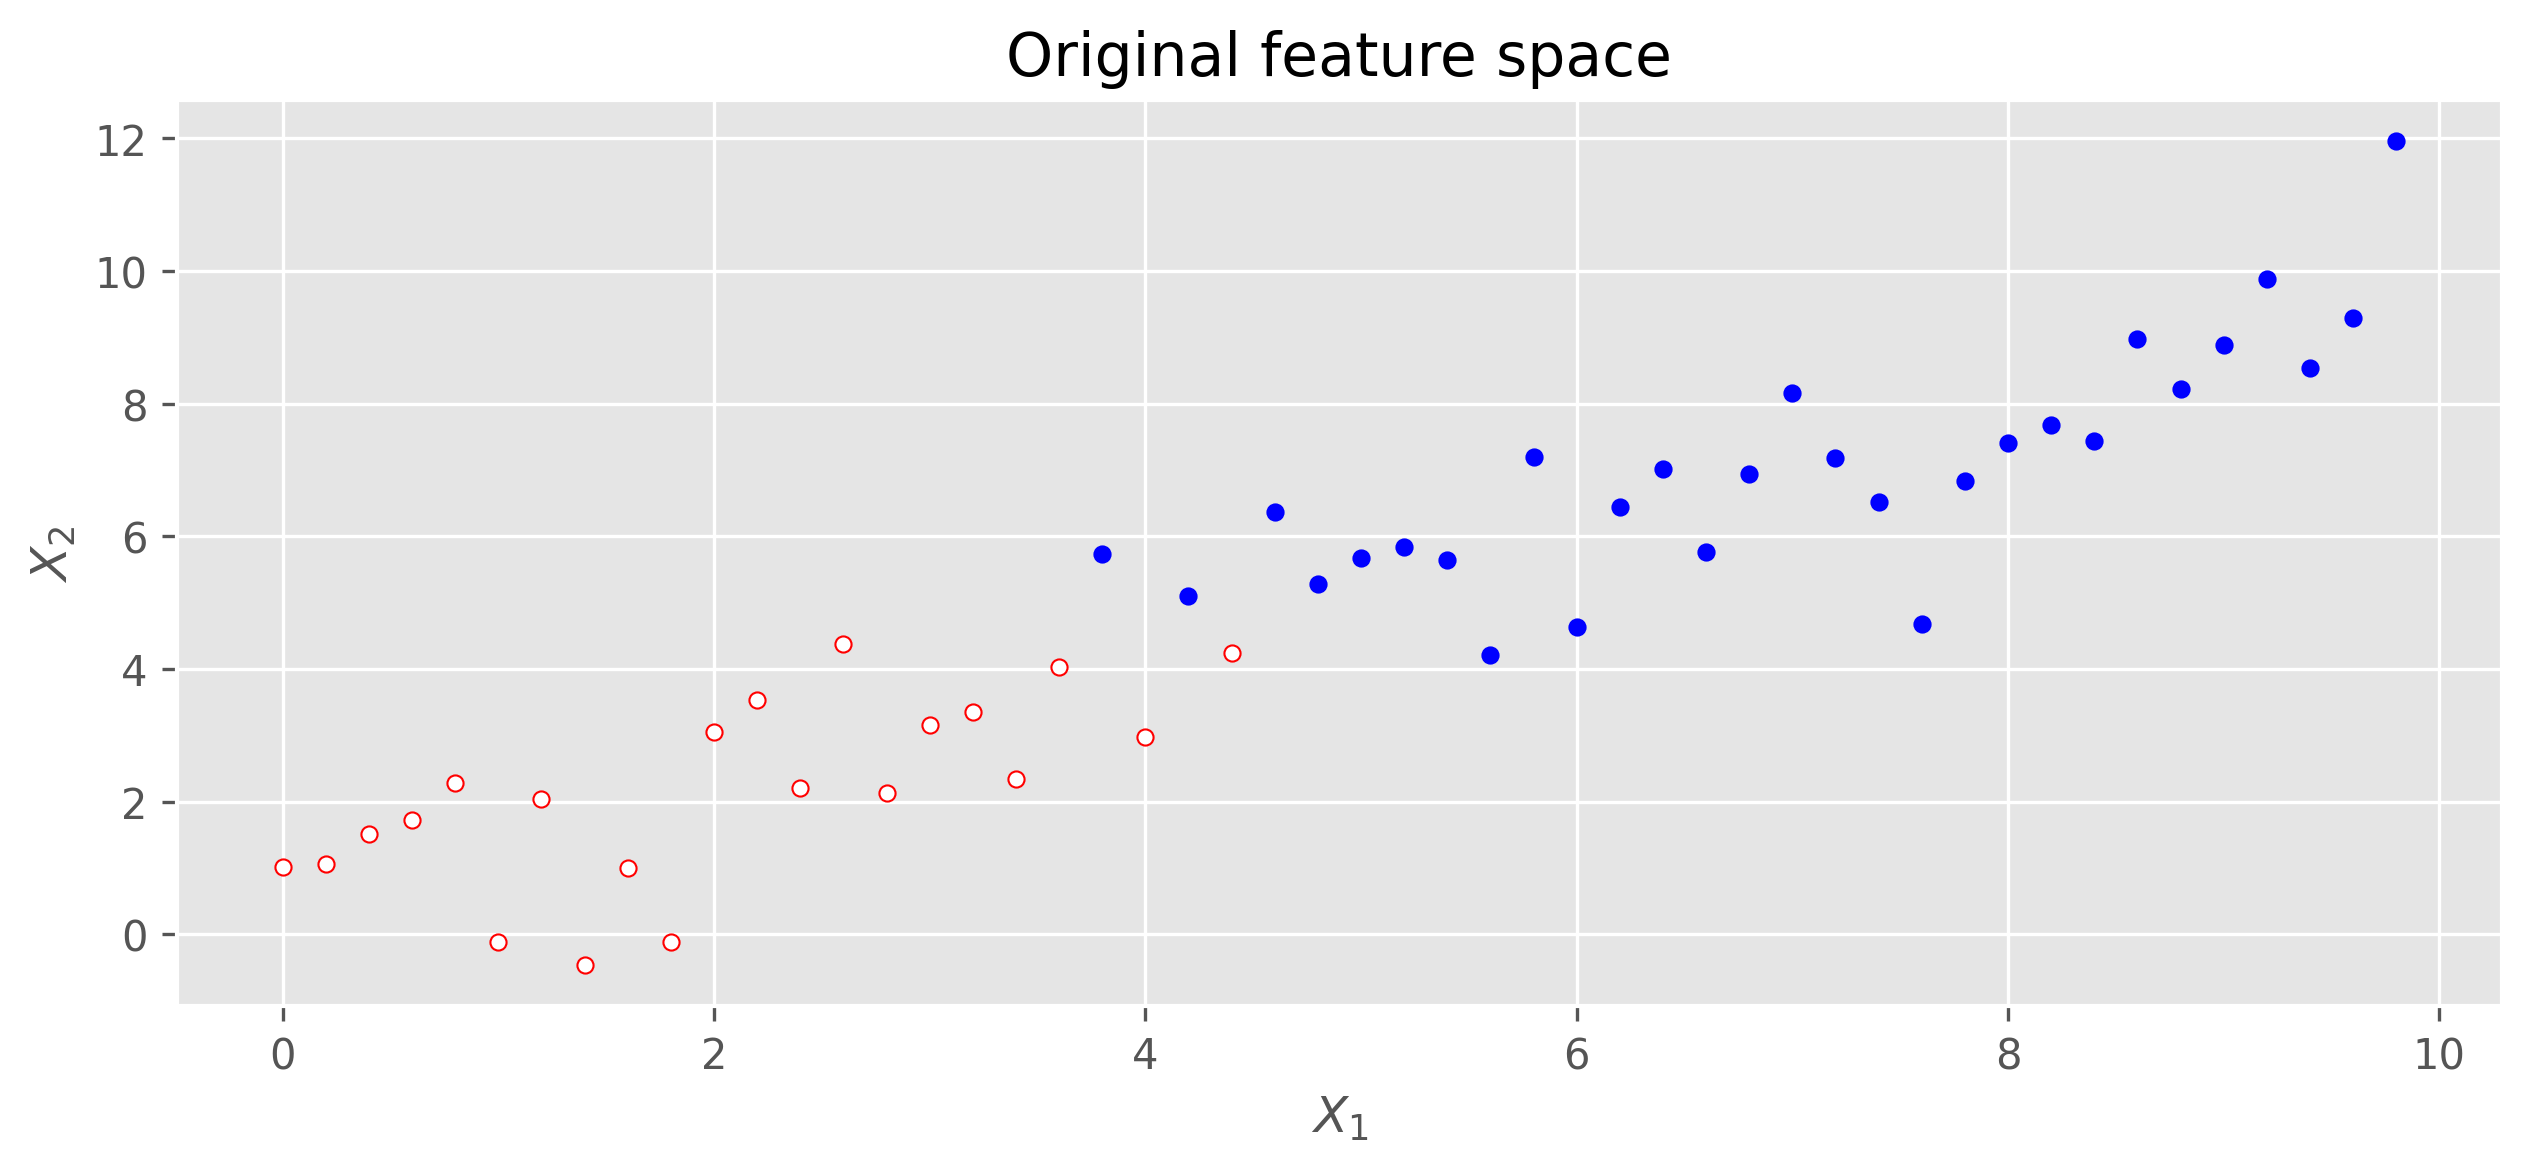

In [9]:
np.random.seed(3)

x1 = np.arange(0, 10, .2)
x2 = x1 + np.random.normal(scale=1, size=len(x1))

plt.clf()
fig = plt.figure(num=None, figsize=(10, 4), dpi=DPI)

plt.title("Original feature space")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

x1 = np.arange(0, 10, .2)
x2 = x1 + np.random.normal(scale=1, size=len(x1))

good = (x1 > 5) | (x2 > 5)
bad = ~good

plt.scatter(x1[good], x2[good], edgecolor="blue", facecolor="blue", s=15)
plt.scatter(x1[bad], x2[bad], edgecolor="red", facecolor="white", s=15)

plt.grid(True)
plt.show()

Scikit-learn provides the PCA class in its decomposition package. In this example, it can be clearly seen that one dimension should be enough to describe the data. This can be specified using the n_components parameter:

In [10]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=1)

Also, here, the fit() and transform() methods of pca (or its fit_transform() combination) can be used to analyze the data and project it in the transformed feature space:

In [11]:
X = np.c_[(x1, x2)]
Xtrans = pca.fit_transform(X)

As it has been specified, Xtrans contains only one dimension. The outcome is even linearly separable in this case. A complex classifier would not be even needed to distinguish between both classes.

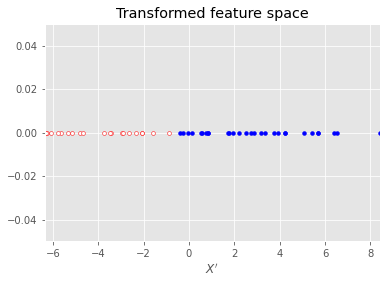

In [12]:
Xg = Xtrans[good]
Xb = Xtrans[bad]

plt.scatter(Xg[:, 0], np.zeros(len(Xg)), edgecolor="blue", facecolor="blue", s=15)
plt.scatter(Xb[:, 0], np.zeros(len(Xb)), edgecolor="red", facecolor="white", s=15)
plt.title("Transformed feature space")
plt.xlabel("$X'$")

plt.grid(True)

plt.autoscale(tight=True)
plt.show()

To get an understanding of the reconstruction error, have a look at the variance of the data that have been retained in the transformation:

In [13]:
print(pca.explained_variance_ratio_)

[0.96393127]


This means that, after going from two dimensions to one, it is still left with 96 percent of the variance.

Of course, it's not always this simple. Frequently, it is unknown about what number of dimensions is advisable upfront. In that case, leave the n_components parameter unspecified when initializing PCA to let it calculate the full transformation. After fitting the data, explained_variance_ratio_contains an array of ratios in decreasing order: the first value is the ratio of the basis vector describing the direction of the highest variance, the second value is the ratio of the direction of the second highest variance, and so on. After plotting this array, it quickly get a feel of how many components it would be needed: the number of components immediately before the chart elbow is often a good guess.

Plots displaying the explained variance over the number of components are called scree plots. A nice example of combining a scree plot with a grid search to find the best setting for the classification problem can be found at https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html.

### Limitations of PCA and how LDA can help

Being a linear method, PCA has, of course, its limitations when it is faced with data that has nonlinear relationships. It's sufficient to say that there are extensions of PCA, for example, Kernel PCA, that introduce nonlinear transformations so that the PCA approach can be still used.

Another interesting weakness of PCA is when it's being applied to special classification problems. If good = (x1 > 5) | (x2 > 5) is replaced with good = x1 > x2 to simulate such a special case, the problem can be quickly seen, as can be seen in the following diagram:

<Figure size 432x288 with 0 Axes>

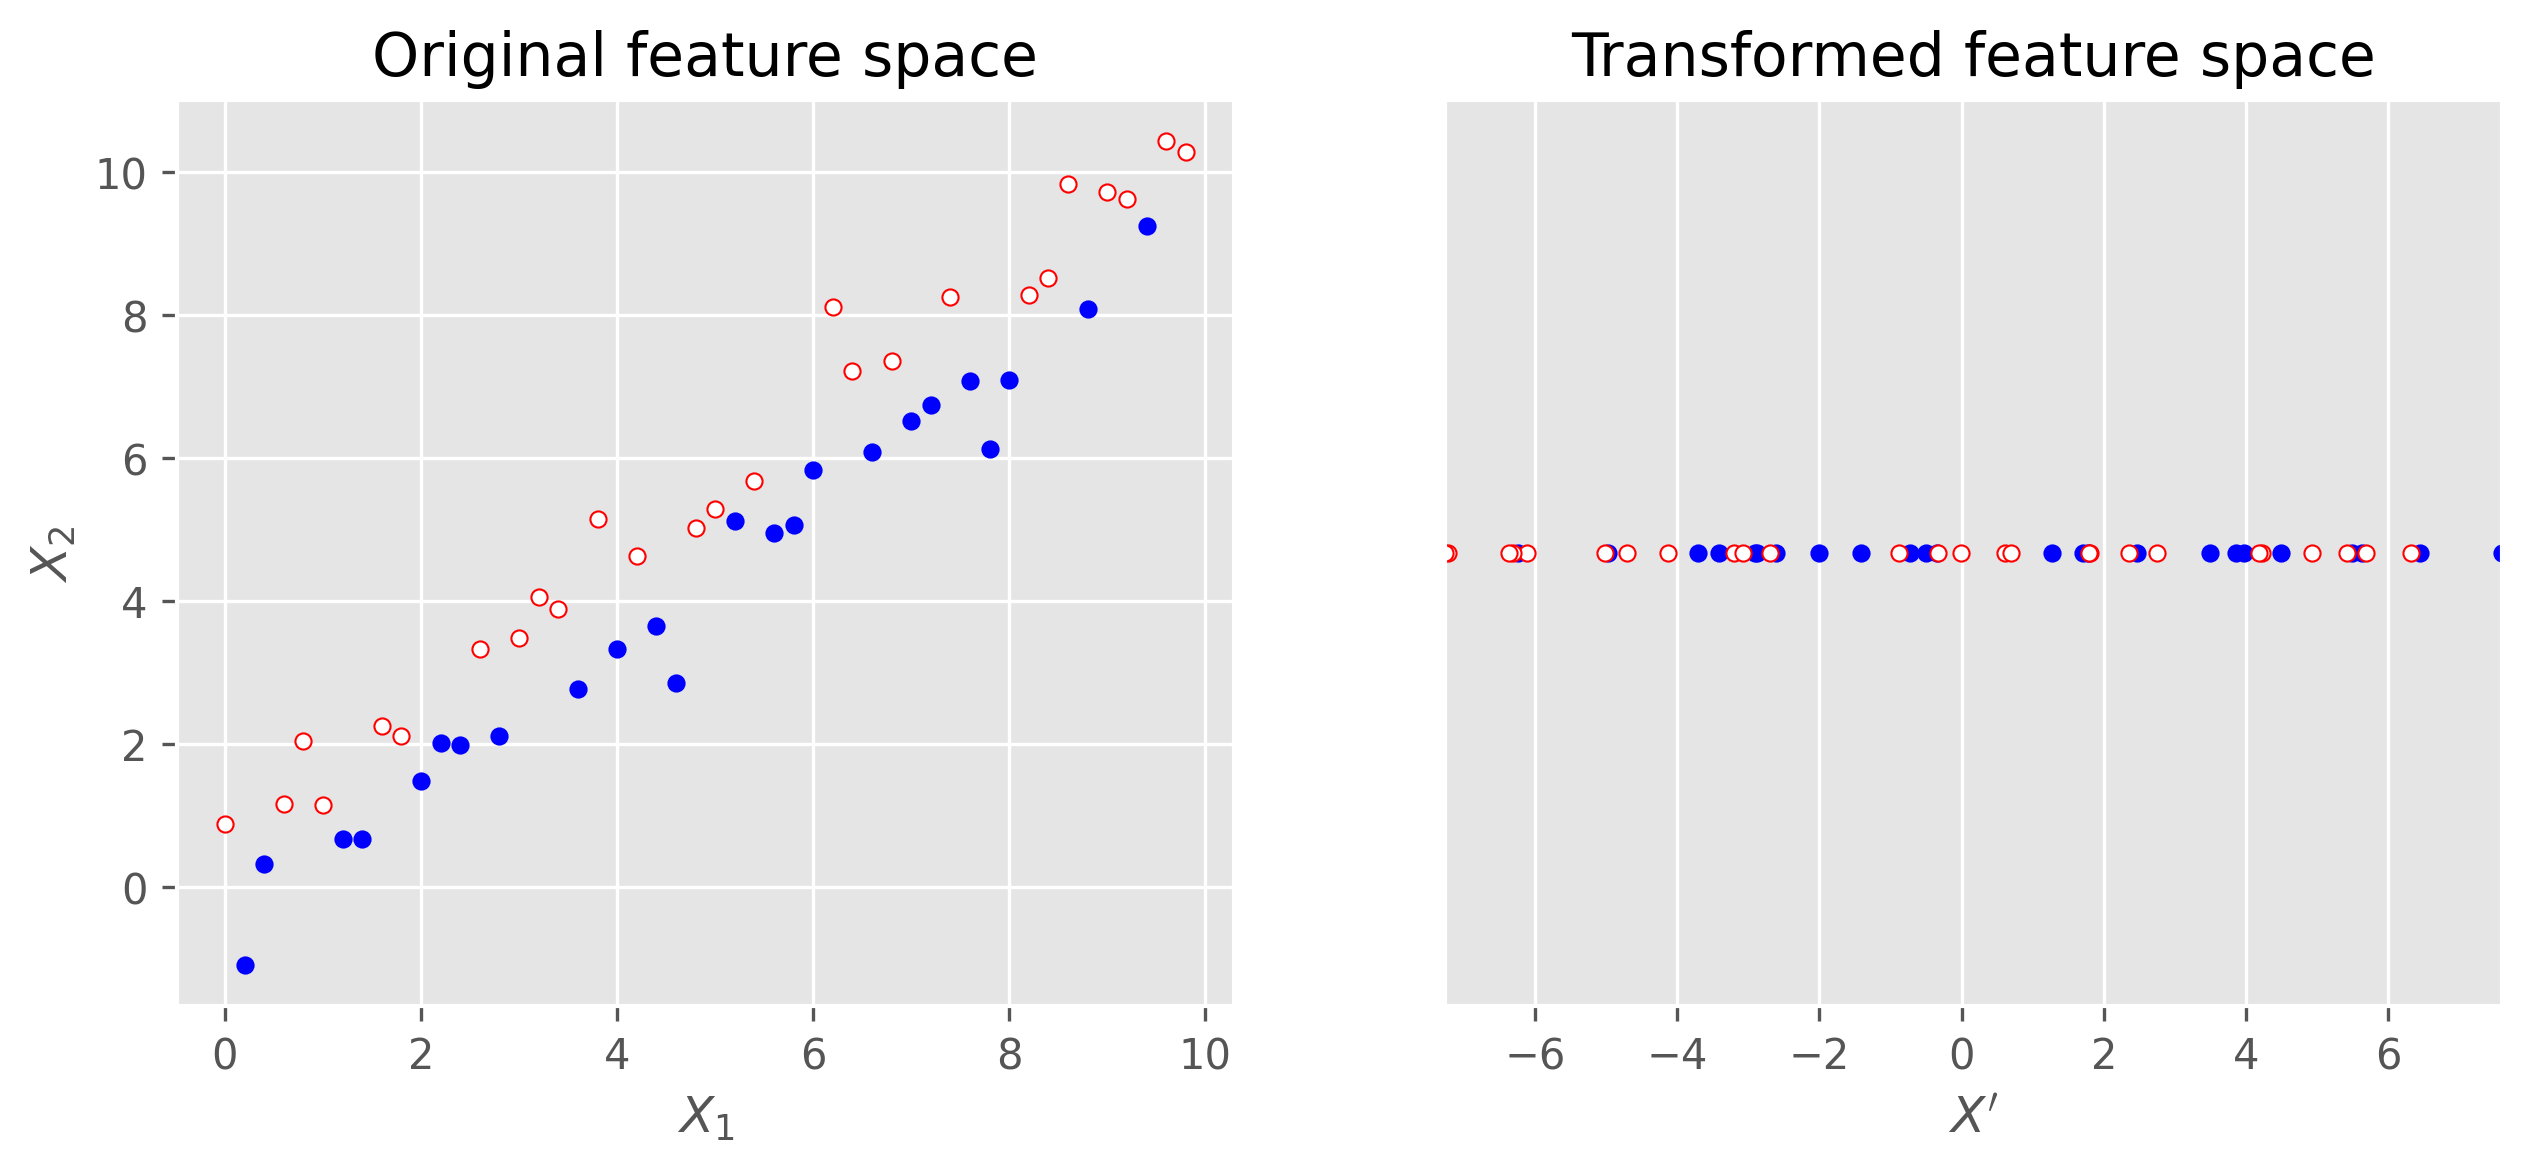

In [14]:
plt.clf()
fig = plt.figure(num=None, figsize=(10, 4), dpi=DPI)
plt.subplot(121)

plt.title("Original feature space")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

x1 = np.arange(0, 10, .2)
x2 = x1 + np.random.normal(scale=1, size=len(x1))

good = x1 > x2
bad = ~good

plt.scatter(x1[good], x2[good], edgecolor="blue", facecolor="blue", s=15)
plt.scatter(x1[bad], x2[bad], edgecolor="red", facecolor="white", s=15)

plt.grid(True)

plt.subplot(122)

X = np.c_[(x1, x2)]

pca = decomposition.PCA(n_components=1)
Xtrans = pca.fit_transform(X)

Xg = Xtrans[good]
Xb = Xtrans[bad]

plt.scatter(Xg[:, 0], np.zeros(len(Xg)), edgecolor="blue", facecolor="blue", s=15)
plt.scatter(Xb[:, 0], np.zeros(len(Xb)), edgecolor="red", facecolor="white", s=15)
plt.title("Transformed feature space")
plt.xlabel("$X'$")
fig.axes[1].get_yaxis().set_visible(False)

plt.grid(True)

plt.autoscale(tight=True)
plt.show()

Here, the classes are not distributed according to the axis with the highest variance, but the axis with the second highest variance. As PCA is not provided with any cues regarding class labels, it cannot do any better.

Linear discriminant analysis (LDA) comes to the rescue here. It's a method that tries to maximize the distance of points belonging to different classes while minimizing the distances of points of the same class. Just a quick tutorial on how to use it, as shown in the following code:

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_inst = LinearDiscriminantAnalysis(n_components=1)
Xtrans = lda_inst.fit_transform(X, good)

That's all. The result looks as expected:

<Figure size 432x288 with 0 Axes>

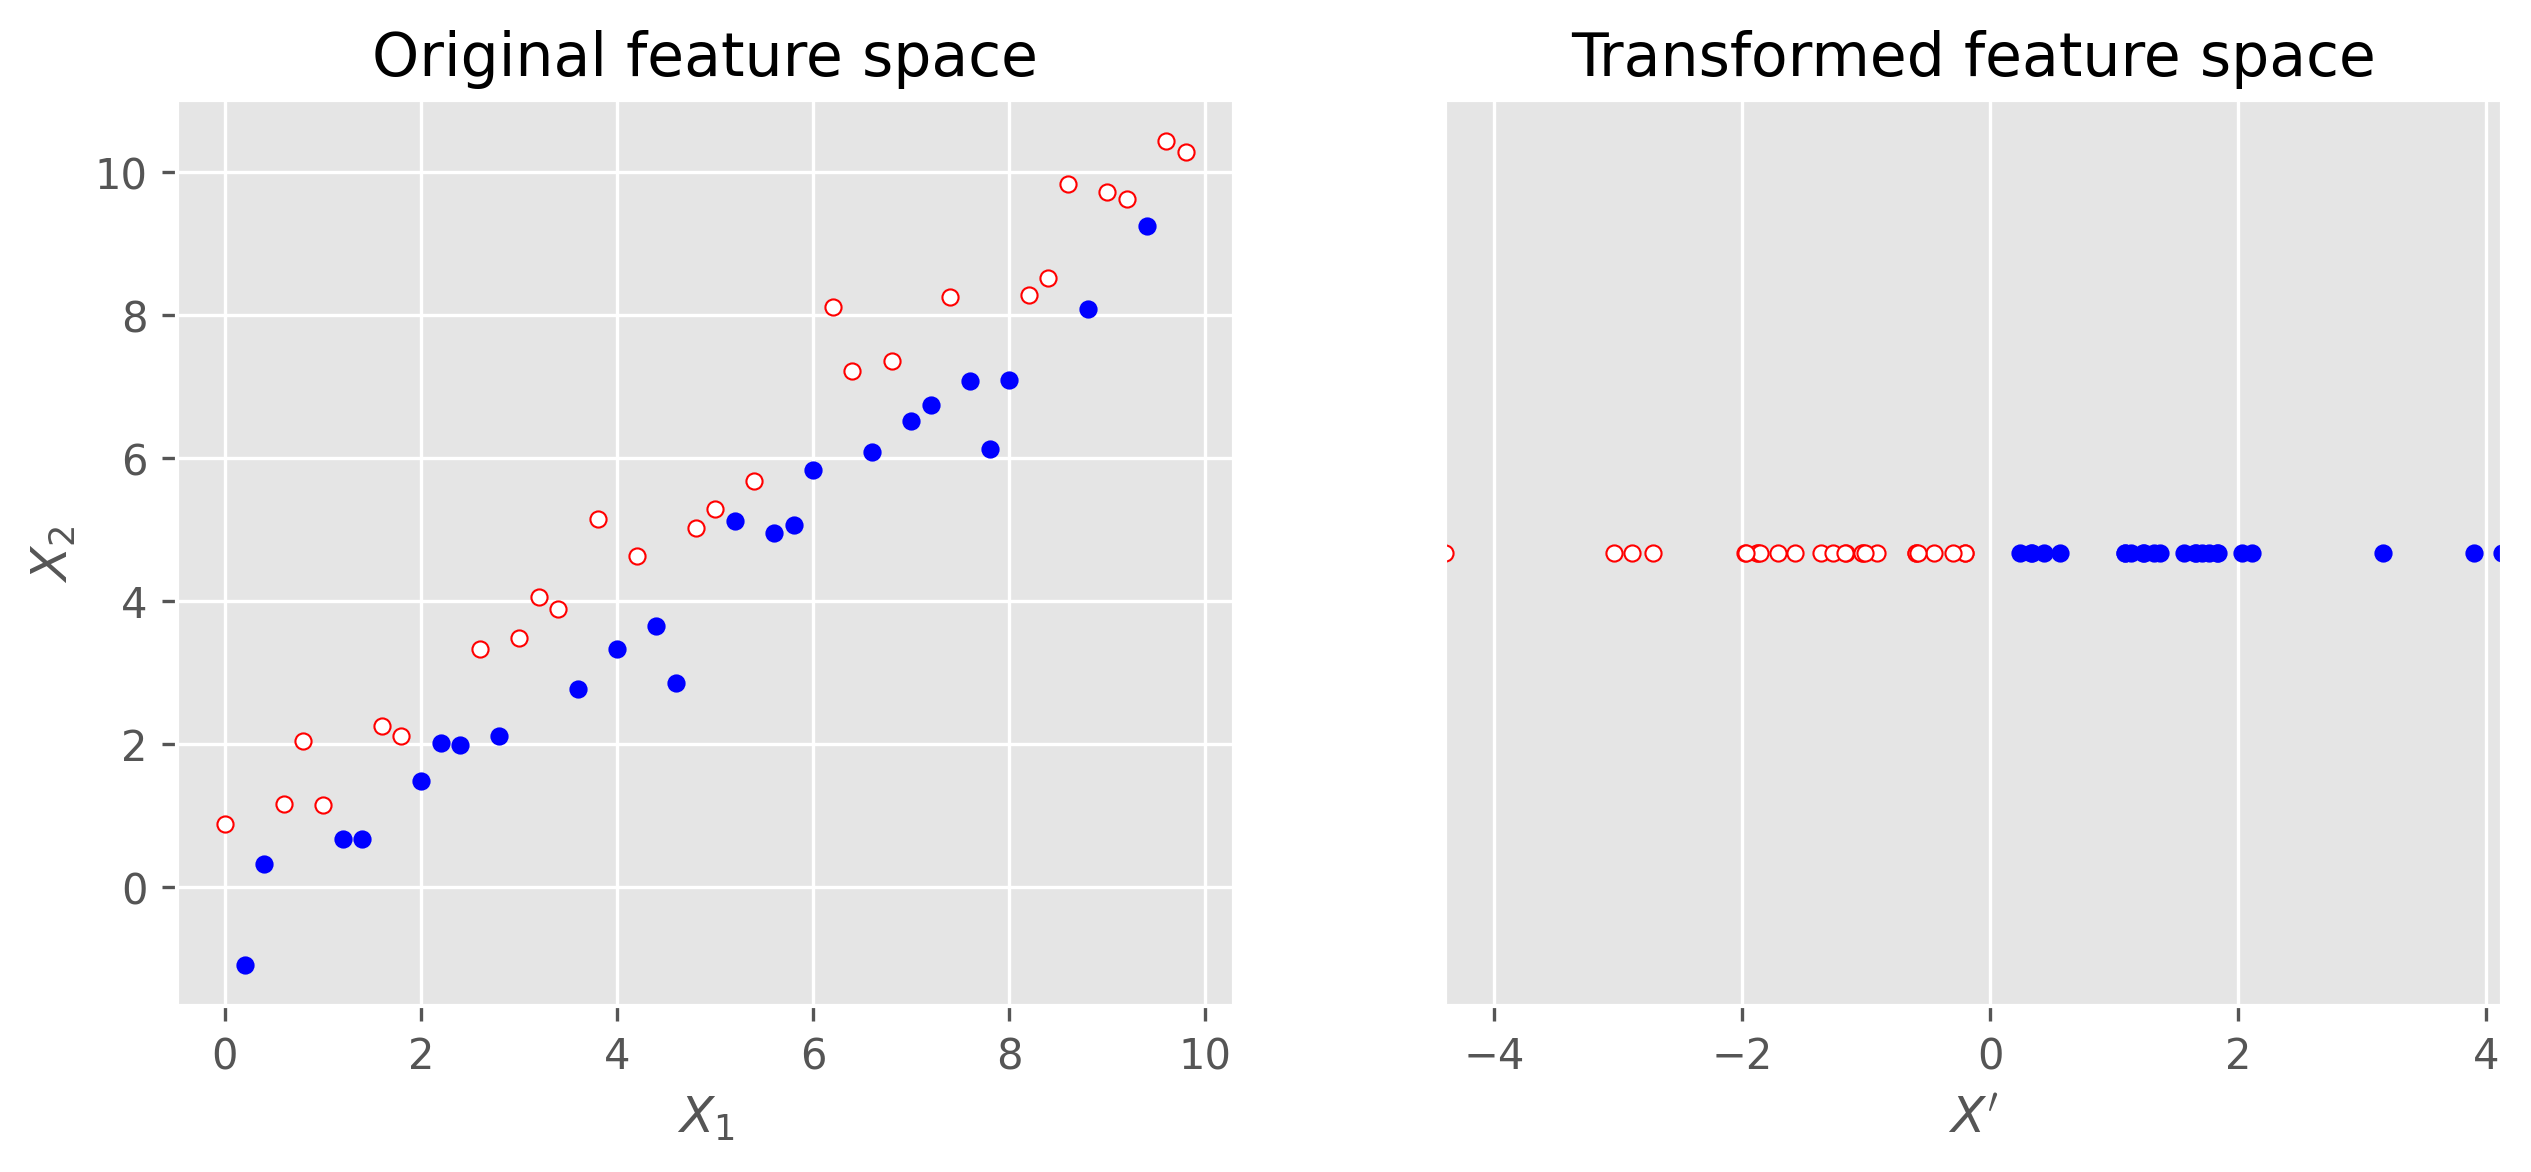

In [16]:
plt.clf()
fig = plt.figure(num=None, figsize=(10, 4), dpi=DPI)
plt.subplot(121)

plt.title("Original feature space")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.scatter(x1[good], x2[good], edgecolor="blue", facecolor="blue", s=15)
plt.scatter(x1[bad], x2[bad], edgecolor="red", facecolor="white", s=15)

plt.grid(True)

plt.subplot(122)

Xg = Xtrans[good]
Xb = Xtrans[bad]

plt.scatter(Xg[:, 0], np.zeros(len(Xg)), edgecolor="blue", facecolor="blue", s=15)
plt.scatter(Xb[:, 0], np.zeros(len(Xb)), edgecolor="red", facecolor="white", s=15)
plt.title("Transformed feature space")
plt.xlabel("$X'$")
fig.axes[1].get_yaxis().set_visible(False)

plt.grid(True)

plt.autoscale(tight=True)
plt.show()

So, why consider PCA at all? Why not simply use LDA?  With an increasing number of classes and fewer samples per class, LDA does not look that good any more. Also, PCA seems to be not as sensitive to different training sets as LDA. So, which method to use it depends.

## Multidimensional scaling

Whereas PCA tries to use optimization for retained variance, multidimensional scaling (MDS) tries to retain the relative distances as much as possible when reducing the dimensions. This is useful when there is a high-dimensional dataset and a visual impression wants to be shown.

MDS does not care about the data points themselves; instead, it's interested in the dissimilarities between pairs of data points and it interprets these as distances. It takes all the N data points of dimension k and calculates a distance matrix using a distance function, d0, which measures the (most of the time, Euclidean) distance in the original feature space:
# ![Multidimensional scaling](./Multidimensional%20scaling.PNG)

Now, MDS tries to position the individual data points in the lower dimensional so such that the new distance there resembles the distances in the original space as much as possible. As MDS is often used for visualization, the choice of the lower dimension is, most of the time, two or three.

Have a look at the following simple data consisting of three data points in five-dimensional space. Two of the data points are close by and one is very distinct, and this will be visualized in three and two dimensions:

In [17]:
import numpy as np

X = np.c_[np.ones(5), 2 * np.ones(5), 10 * np.ones(5)].T
print(X)

[[ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [10. 10. 10. 10. 10.]]


Using the MDS class in scikit-learn's manifold package, first specify that we want to transform X into a three-dimensional Euclidean space:

In [18]:
from sklearn import manifold

mds = manifold.MDS(n_components=3)
Xtrans = mds.fit_transform(X)

To visualize it in two dimensions, n_components would need to be set accordingly.

The results can be seen in the following two graphs. The triangle and circle are both close together, whereas the star is far away:

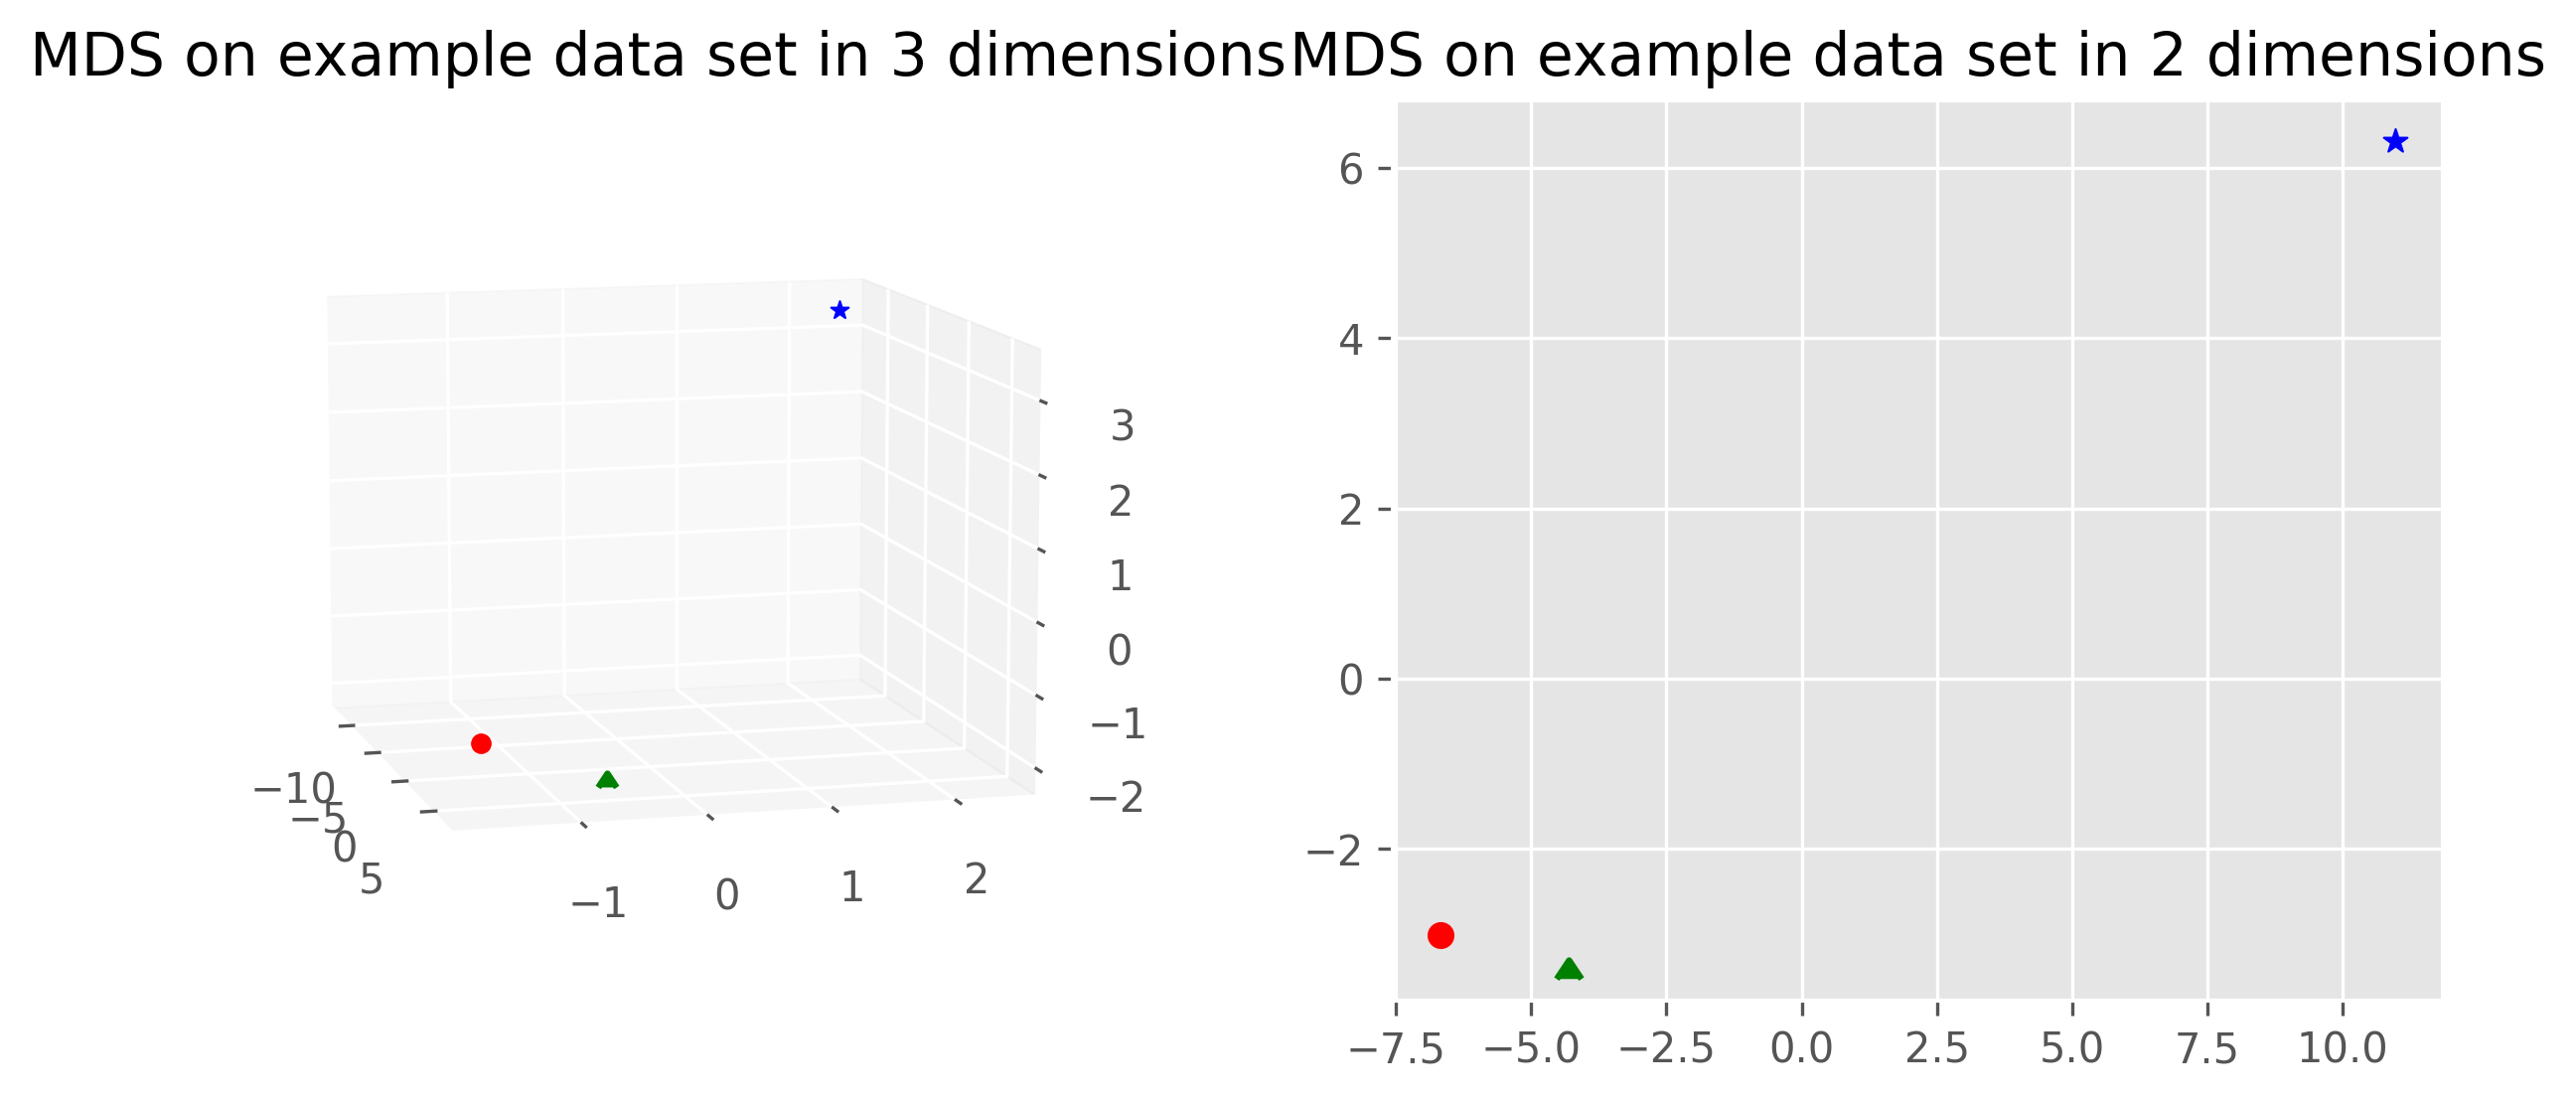

In [19]:
np.random.seed(3)

# all examples will have three classes in this file
colors = ['r', 'g', 'b']
markers = ['o', 6, '*']

fig = plt.figure(figsize=(10, 4), dpi=DPI)

ax = fig.add_subplot(121, projection='3d')
ax.set_facecolor('white')

y = np.array([0, 1, 2])

for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], Xtrans[y == cl][:, 2], c=color, marker=marker)
plt.title("MDS on example data set in 3 dimensions")
ax.view_init(10, -15)

mds = manifold.MDS(n_components=2)
Xtrans = mds.fit_transform(X)

ax = fig.add_subplot(122)
for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], c=color, marker=marker)
plt.title("MDS on example data set in 2 dimensions")
plt.show()

Have a look at the slightly more complex Iris dataset. In the previous example, a metric was not specifed, so MDS will default to Euclidean. This means that flowers that were different according to their four attributes should also be far away in the MDS-scaled, three-dimensional space, and flowers that were similar should be almost together now, as shown in the following diagram:

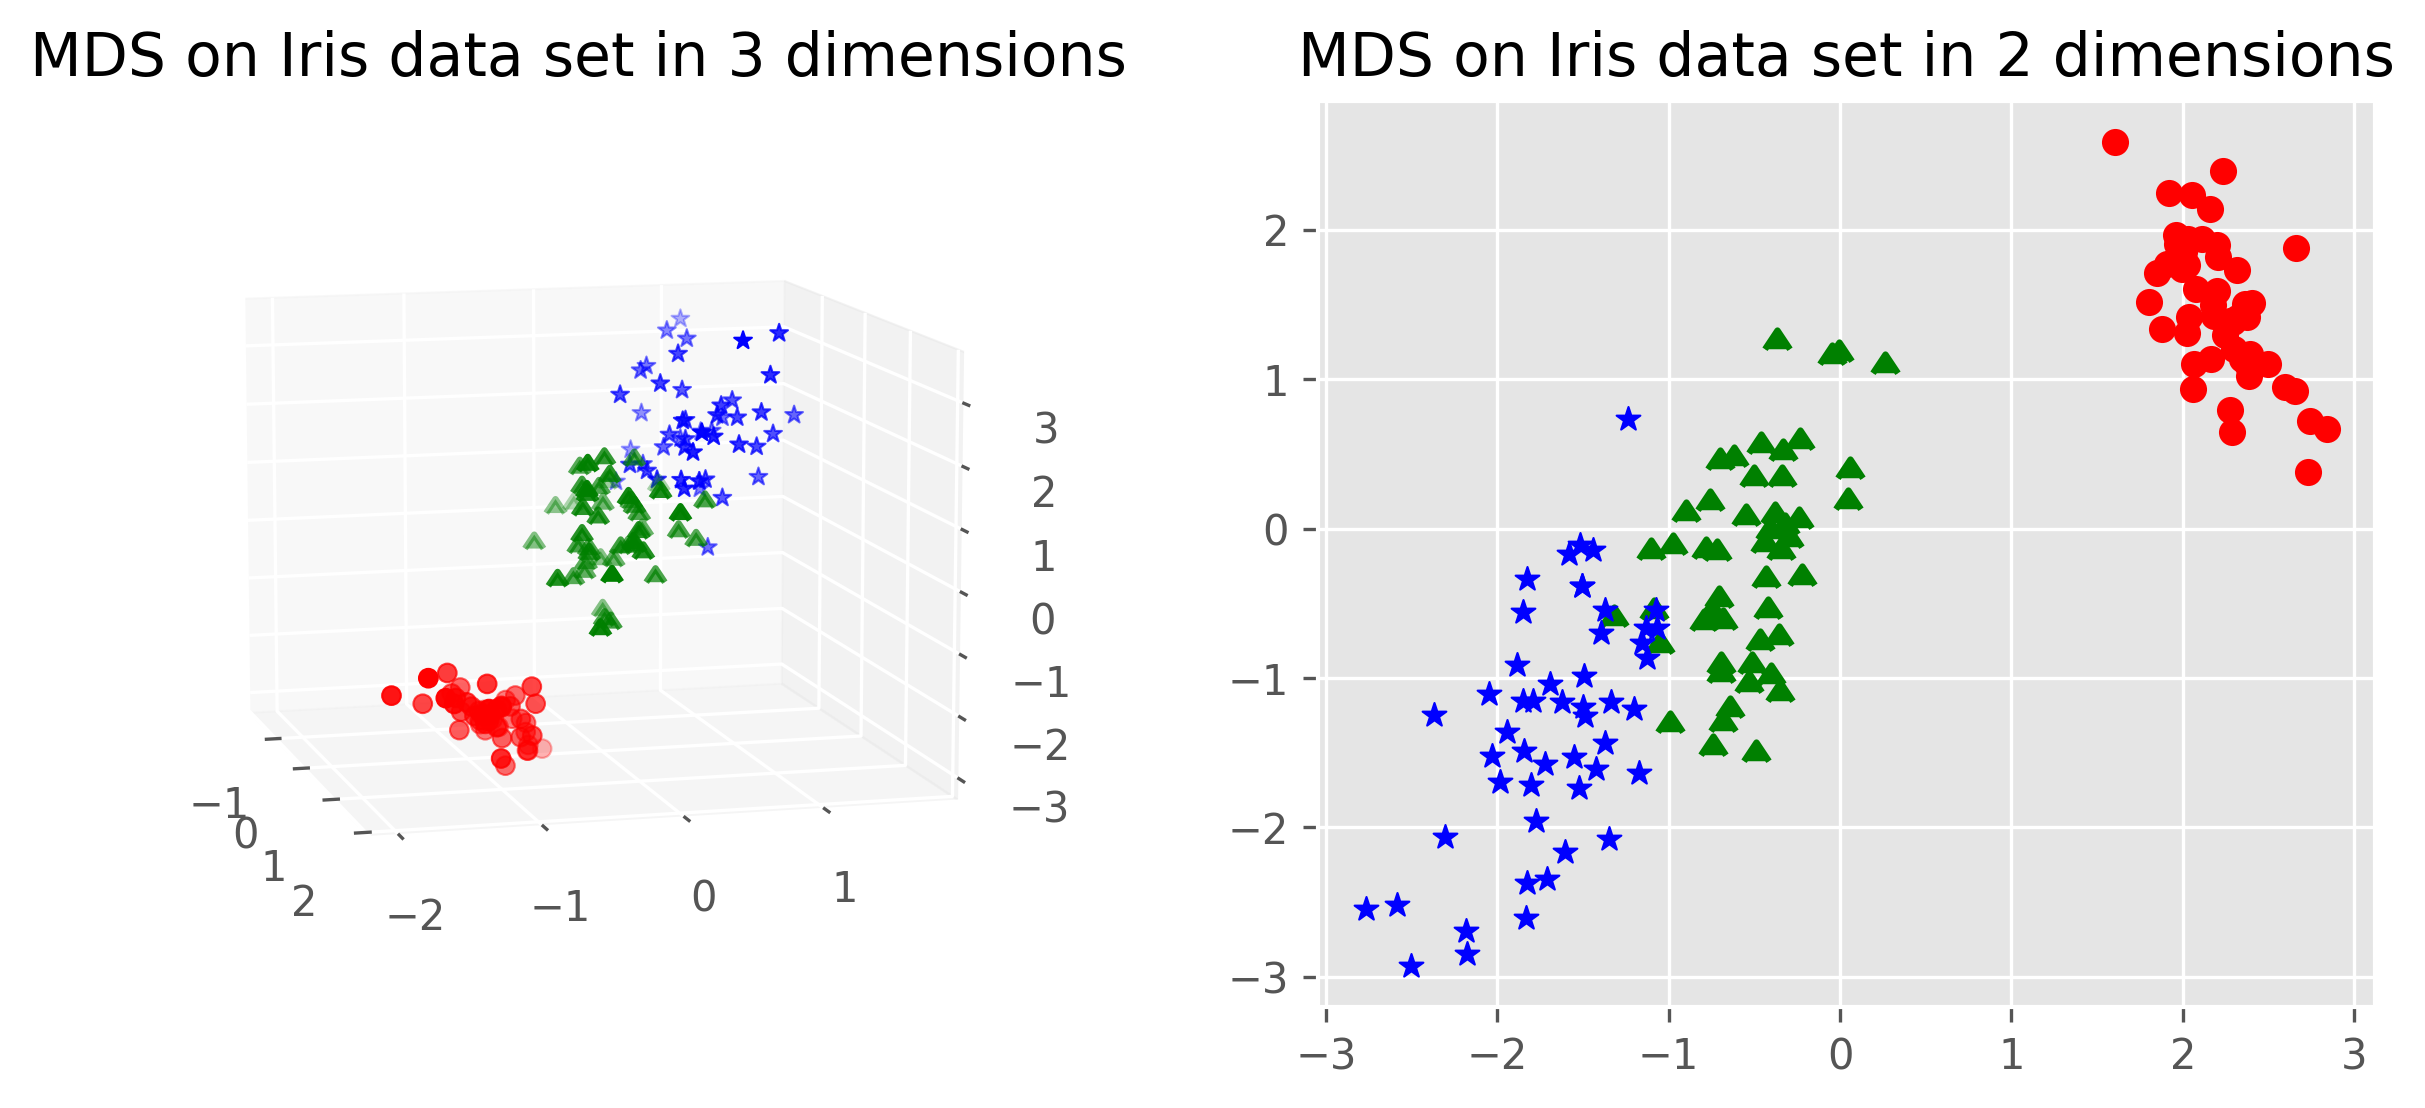

In [20]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

# MDS

fig = plt.figure(figsize=(10, 4), dpi=DPI)

ax = fig.add_subplot(121, projection='3d')
ax.set_facecolor('white')

mds = manifold.MDS(n_components=3)
Xtrans = mds.fit_transform(X)

for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], Xtrans[y == cl][:, 2], c=color, marker=marker)
plt.title("MDS on Iris data set in 3 dimensions")
ax.view_init(10, -15)

mds = manifold.MDS(n_components=2)
Xtrans = mds.fit_transform(X)

ax = fig.add_subplot(122)
for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], c=color, marker=marker)
plt.title("MDS on Iris data set in 2 dimensions")
plt.show()

Reducing the dimensionality to three and two dimensions with PCA instead, the expected larger spread of flowers belonging to the same class is seen:

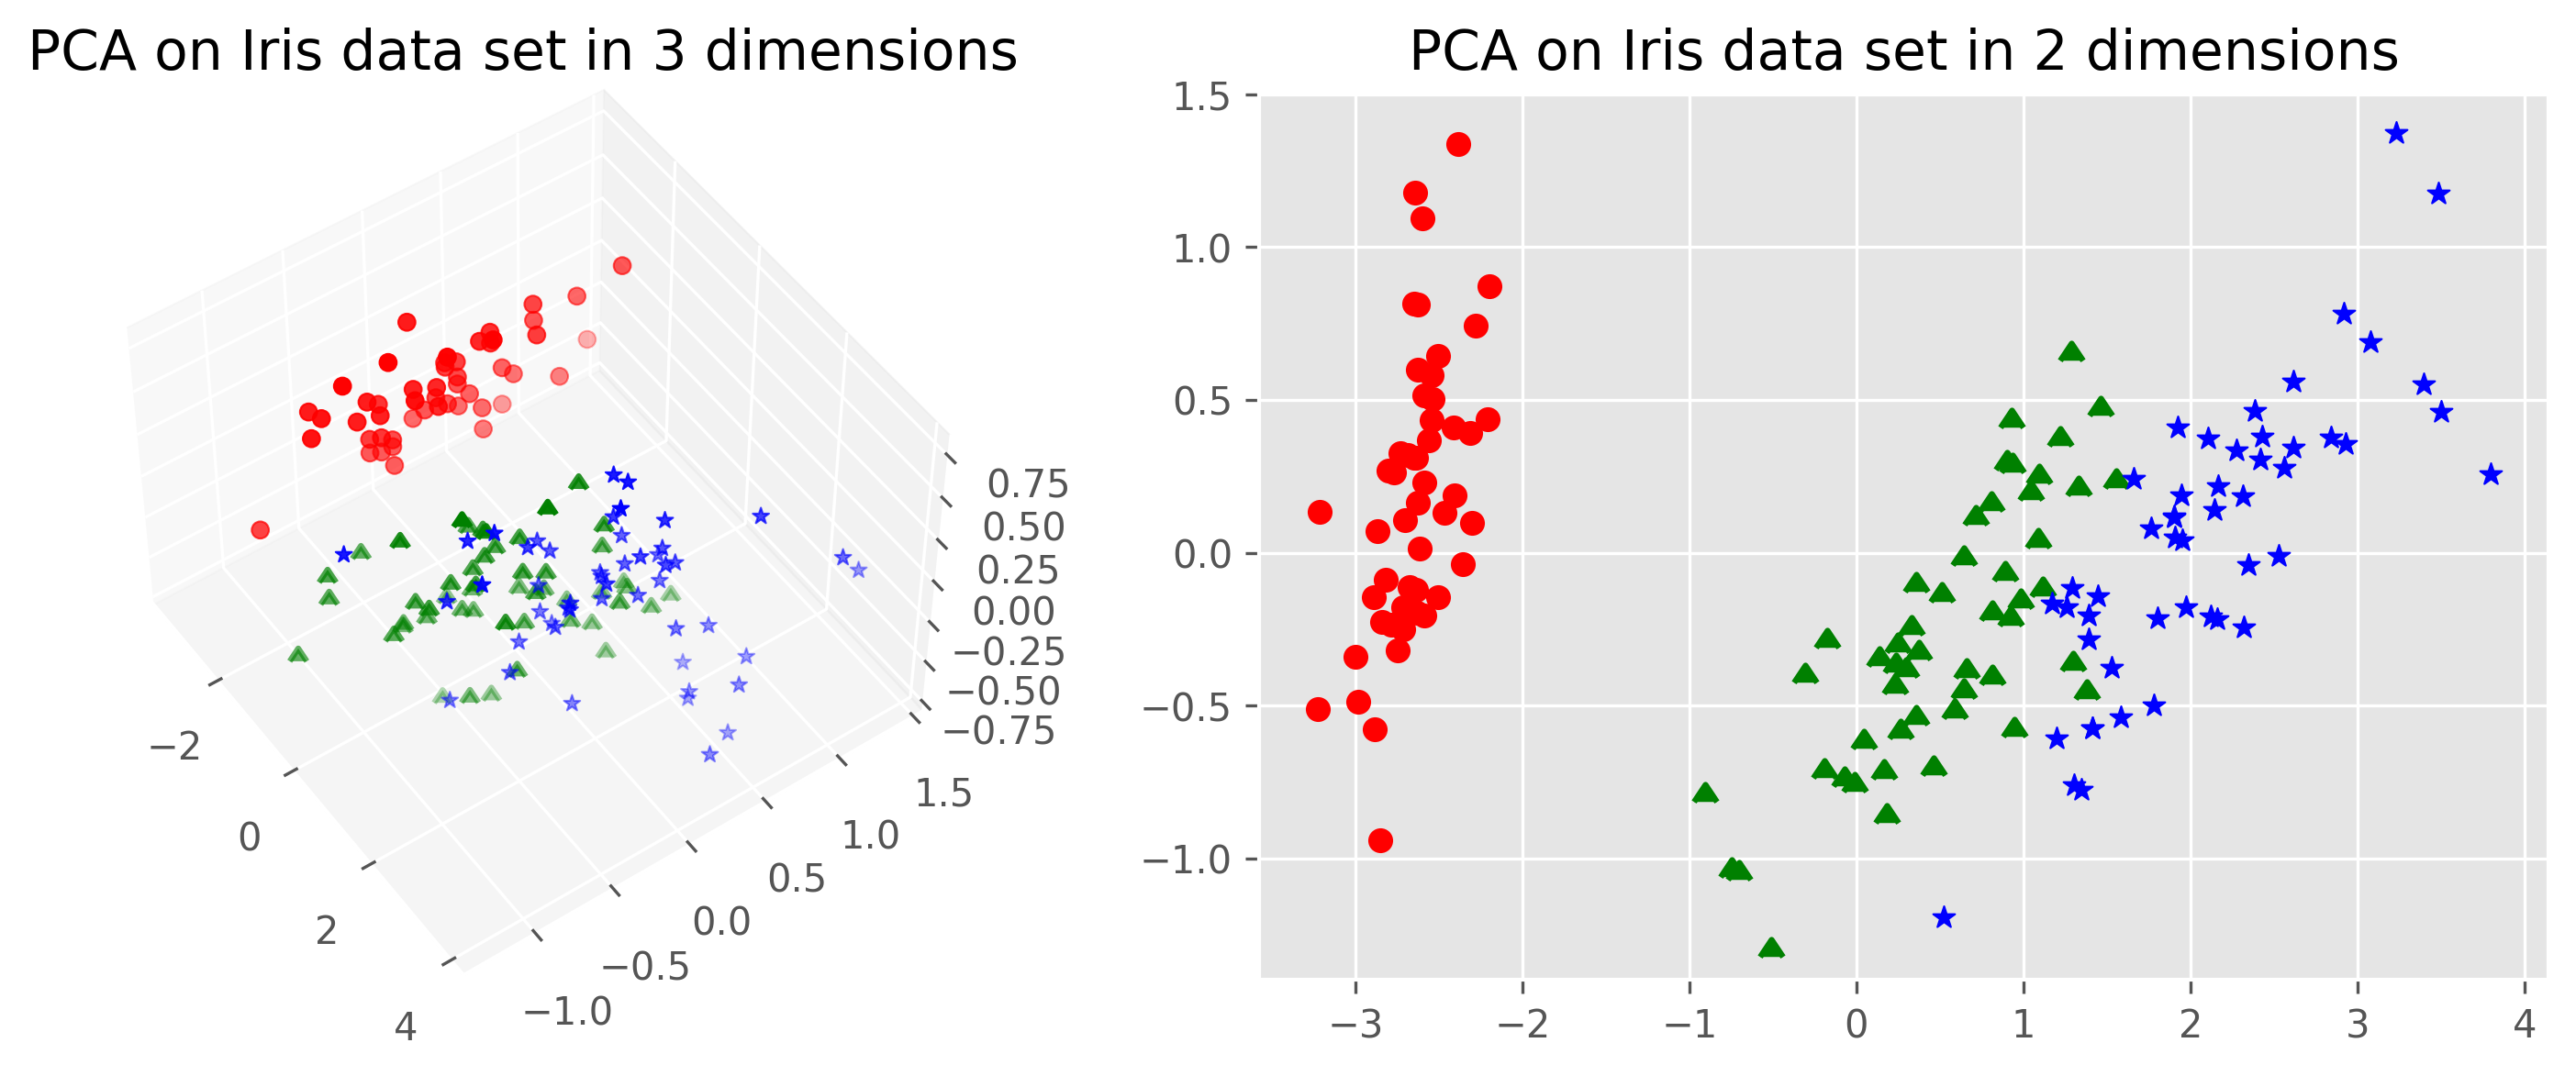

In [21]:
fig = plt.figure(figsize=(10, 4), dpi=DPI)

ax = fig.add_subplot(121, projection='3d')
ax.set_facecolor('white')

pca = decomposition.PCA(n_components=3)
Xtrans = pca.fit(X).transform(X)

for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], Xtrans[y == cl][:, 2], c=color, marker=marker)
plt.title("PCA on Iris data set in 3 dimensions")
ax.view_init(50, -35)

pca = decomposition.PCA(n_components=2)
Xtrans = pca.fit_transform(X)

ax = fig.add_subplot(122)
for cl, color, marker in zip(np.unique(y), colors, markers):
    ax.scatter(Xtrans[y == cl][:, 0], Xtrans[y == cl][:, 1], c=color, marker=marker)
plt.title("PCA on Iris data set in 2 dimensions")
plt.tight_layout()
plt.show()

Of course, using MDS requires an understanding of the individual feature's units; maybe features are being used cannot be compared using the Euclidean metric. For instance, a categorical variable, even when encoded as an integer (0 = circle, 1 = star, 2 = triangle, and so on), cannot be compared using a Euclidean metric (is a circle closer to a star than to triangle?).

However, once this issue is aware of, MDS is a useful tool that reveals similarities in the data that would otherwise be difficult to see in the original feature space.

Looking a bit deeper into MDS, it's not a single algorithm, but rather a family of different algorithms. Also, neither PCA nor MDS solves the problem, just look at the many other learning and embedding algorithms that are available in the scikit-learn toolkit.

However, before get overwhelmed by the many different algorithms, it's always best to start with the simplest one and see how far it get. Then, take the next more complex one and continue from there.

## Autoencoders, or neural networks for dimensionality reduction

A little bit more than a decade ago, the main tool for dimensionality reduction with neural networks was Kohonen maps, or self-organizing maps (SOM). Since then, with faster computers, it is now possible to use deep learning to create embedded spaces.

The trick is to have an intermediate layer that has fewer nodes than the input layer and an output layer that must reproduce the input layer. The data on this intermediate layer will give the coordinates in an embedded space.

If regular dense layers is used without a specific activation function, a linear function is resulted from the input to the embedded layer to the output layer. More than one layer to the embedded layer will not change the result of the training and, as such, a linear embedding is obtained such as PCA (without the constraint of having an orthogonal basis in the embedded layer).

Adding a nonlinear activation function to the dense layer is what will enable finding manifolds in data, instead of just hyperplans. As opposed to tools such as Isomap, which try to match distances between data (it's a variant of MDS, trying to match approximated geodesic distances instead of Euclidian distances), or Laplacian eigenmaps, which try to match similarities between data, autoencoders have no concept of what things are being tried to be kept—they will just attempt to reproduce whatever it is provided at the input.

Neural networks can extract features from data, as it will be seen in the TensorFlow chapter, but things will be kept simple here by using a dataset that is features-only.

The dataset we will be considering is the Swiss Roll. It is one of the most famous datasets used in manifold, as it's a nonlinear dataset that can be easily understood by human eyes, but that is wrapped enough to make it difficult for algorithms to properly describe it:

In [22]:
import numpy as np

max = 4
def generate_swissroll(n):
    """
    Generates data for the swissroll
    Returns the parameter space, the swissroll
    """
    orig = np.random.random((2, n)) * max
    return (orig.T, np.array((orig[1] * np.cos(orig[1]), orig[1] * np.sin(orig[1]), orig[0])).T)

def color_from_parameters(params):
    """
    Defines a color scheme for the swissroll
    """
    return np.array((params[:,0], params[:,1], max - params[:,1])).T / max

def plot_3d(swissroll, colors):  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(swissroll[:, 0], swissroll[:, 2], swissroll[:, 1], c=colors)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Z axis')
    ax.set_zlabel('Y axis')
    plt.show()

def plot_2d(swissroll, colors):    
    fig = plt.figure()
    plt.scatter(swissroll[:,0], swissroll[:,1], c=colors)
    plt.xlabel('Param 1')
    plt.ylabel('Param 2')
    plt.show()

From these functions, new data can be generated along with a color code that will allow it to be checked that the embedded data matches the original parameters that was used, as shown in the following diagram:

Original manifold


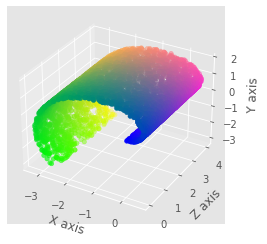

In [23]:
n = 5000

params, swissroll = generate_swissroll(n)
params_test, swissroll_test = generate_swissroll(n)
colors = color_from_parameters(params)
colors_test = color_from_parameters(params_test)
print("Original manifold")
plot_3d(swissroll, colors)

It is now time to think of the architecture that will be used. Start with the input layer that will feed the data inside the network using two layers that will do the heavy lifting of unwrapping the input data into the embedded layer with two layers. To rebuild the Swiss Roll, another dense layer will be used before ending on the three-unit output layer. To create the nonlinearities, each of the layers (except the input) will use a leaky_relu activation. The arrangement is shown in the following diagram:
# ![Autoencoder architecture](./Autoencoder%20architecture.PNG)

Create the scaffolding:

In [24]:
import tensorflow as tf

def tf_create_dense_layer(x, size):
    x = tf.keras.layers.Dense(size, kernel_initializer='glorot_normal')(x)
    return tf.keras.layers.LeakyReLU()(x)

This time, the autoencoder will be encapsulated in a class. The constructor will create the variables, and the train method will run the optimization, as well as create a few display images.

When the layers are built, the embedded layer variable is saved, as this variable is the one will be used to get the parameters of a new sample in the embedded space:

In [25]:
class Autoencoder(object):
    def __init__(self, swissroll, swissroll_test, nb_intermediate, learning_rate):
        self.swissroll = swissroll
        self.swissroll_test = swissroll_test
        self.nb_intermediate = nb_intermediate
        self.learning_rate = learning_rate
        encoder_input = tf.keras.Input(shape=(swissroll.shape[1],))
        intermediate_input = tf_create_dense_layer(encoder_input, self.nb_intermediate)
        intermediate_input = tf_create_dense_layer(intermediate_input, self.nb_intermediate)
        encoder_output = tf_create_dense_layer(intermediate_input, 2)
        self.encoded = tf.keras.Model(encoder_input, encoder_output, name="encoder")
        intermediate_output = tf_create_dense_layer(encoder_output, self.nb_intermediate)
        decoder_output = tf_create_dense_layer(intermediate_output, swissroll.shape[1])
        self.output = tf.keras.Model(inputs=encoder_input, outputs=decoder_output, name="autoencoder")
        self.my_opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    
    def train_step(self, swissroll_tf):
        with tf.GradientTape() as tape:
            Y_tf = self.output(swissroll_tf, training=True)
            self.meansq = tf.reduce_mean(tf.math.squared_difference(Y_tf, swissroll_tf))
        gradients = tape.gradient(self.meansq, self.output.trainable_weights)
        self.my_opt.apply_gradients(zip(gradients, self.output.trainable_weights))
        return self.meansq
    
    def train(self, display, n_epochs, batch_size, step, **kwargs):
        n = len(self.swissroll)
        for i in range(n_epochs):
            permut = np.random.permutation(n)
            for j in range(0, n, batch_size):
                samples = permut[j:j+batch_size]
                batch = self.swissroll[samples]
                self.train_step(batch)
            if i % step == step - 1:
                print("Epoch :{} \n Loss {}".format(i, self.meansq))
        error = tf.reduce_mean(tf.math.squared_difference(self.output(self.swissroll, training=True), self.swissroll))
        error_test = tf.reduce_mean(tf.math.squared_difference(self.output(self.swissroll_test, training=True), self.swissroll_test))
        if display:
            pred = self.encoded(self.swissroll, training=False)
            pred = np.asarray(pred)
            recons = self.output(self.swissroll, training=False)
            recons = np.asarray(recons)
            recons_test = self.output(self.swissroll_test, training=False)
            recons_test = np.asarray(recons_test)
            print("Embedded manifold")
            plot_2d(pred, colors)
            plt.show()
            print("Reconstructed manifold")
            plot_3d(recons, colors)
            plt.show()
            print("Reconstructed test manifold")
            plot_3d(recons_test, kwargs['colors_test'])
            plt.show()
        return error, error_test

This autoencoder can be run and checked whether it also works on new data:

Epoch :99 
 Loss 0.051177412271499634
Epoch :199 
 Loss 0.023670082911849022
Epoch :299 
 Loss 0.0054945796728134155
Epoch :399 
 Loss 0.005440255161374807
Epoch :499 
 Loss 0.0030893939547240734
Epoch :599 
 Loss 0.0014475258067250252
Epoch :699 
 Loss 0.001600333140231669
Epoch :799 
 Loss 0.0009782182751223445
Epoch :899 
 Loss 0.0024963286705315113
Epoch :999 
 Loss 0.00107959087472409
Epoch :1099 
 Loss 0.001117489649914205
Epoch :1199 
 Loss 0.0009006435866467655
Epoch :1299 
 Loss 0.0018865963211283088
Epoch :1399 
 Loss 0.0011490219039842486
Epoch :1499 
 Loss 0.0011416710913181305
Epoch :1599 
 Loss 0.0014630742371082306
Epoch :1699 
 Loss 0.0015629490371793509
Epoch :1799 
 Loss 0.0008436687057837844
Epoch :1899 
 Loss 0.0009068167419172823
Epoch :1999 
 Loss 0.0009602586505934596
Embedded manifold


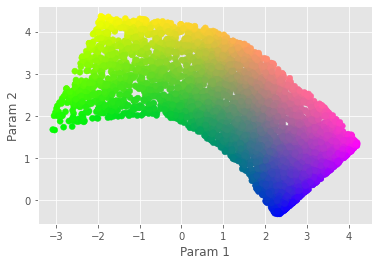

Reconstructed manifold


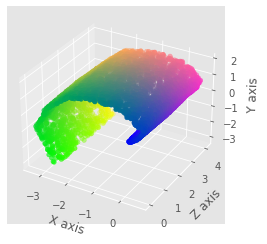

Reconstructed test manifold


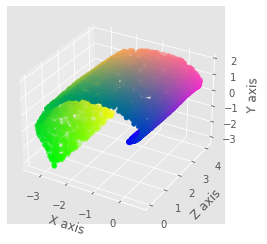

In [26]:
n_epochs = 2000
batch_size = 100
nb_intermediate = 20
learning_rate = 0.05
step = 100

model = Autoencoder(swissroll, swissroll_test, nb_intermediate, learning_rate)
error, error_test = model.train(True, n_epochs, batch_size, step=step, colors=colors, test=swissroll_test, colors_test = colors_test)

The embedded space for the training data is fine, and respects the color scheme that was used for generating the swissroll. A representation of it can be seen in the first diagram.

An interesting point here is that the parameter space is not directly linked to the parameters that is used to create the data. A regularization could be added in the mean square cost function, just like it was done in the chapter on regression.

A crucial point is to check that the output data also matches the input data. The second diagram shows a graphical representation.

It can be seen that there are some bumps and discontinuities compared to the original Swiss Roll. Adding a second layer during reconstruction would help reduce this; it was not done here to show that it doesn't have to use a symmetric neural network for autoencoders.